# Final project:  Yelp Review Analysis

In [1]:
from scipy.stats import zscore
from scipy import sparse
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import os , io
from sklearn import preprocessing
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
import requests
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid", color_codes = True,font_scale = 1.5)
from datetime import datetime
from IPython.display import display, Markdown
import random
import re
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
!pip install WordCloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, ClassifierMixin
import string
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('stopwords')
%config InlineBackend.figure_format='retina'

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to C:\Users\Kylie
[nltk_data]     Vo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## The data

### Description of data

The Yelp dataset is downloaded from the Yelp website. This set includes information about local businesses in 10 metropolitan areas across 2 countries. From the review and business tables, we attracted only the restaurants from the total of 1290 categories.

Attribues of atracted table are as following:

- business_id: ID of the business
- name: name of the business
- address: address of the business
- city: city of the business
- state: state of the business
- postal_code: postal code of the business
- latitude: latitude of the business
- longitude: longitude of the business
- stars: average rating of the business
- categories: multiple categories of the business
- review_id: ID of the review
- review_stars: ratings of the business
- useful: number of users who vote a review as usefull
- funny: number of users who vote a review as funny
- cool: number of users who vote a review as cool
- text: review from the user

## Import data

In [2]:
review_business_sample = pd.read_csv("yelp_reviews_restaurants_clean.csv")

In [3]:
initial_load = pd.read_csv('yelp_reviews_restaurants.csv')

## Clean data & Get sample (20%)

In [4]:
initial_load = initial_load[['business_id', 'review_stars', 'text', 'cool', 'useful', 'funny'  ]]
clean_yelp_2 = initial_load[initial_load.review_stars.isna() == False]
clean_yelp_1 = clean_yelp_2[clean_yelp_2.review_stars != '']
clean_yelp = clean_yelp_1.fillna('')
clean_yelp['text length'] = clean_yelp['text'].str.len()
clean_yelp['review_stars'] = clean_yelp['review_stars'].astype(int)
yelp = clean_yelp.sample(frac = .04, random_state = 42)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## EAD

In [5]:
yelp.shape

(142671, 7)

In [6]:
yelp.head()

business_id  review_stars  \
706237   XSGSWu7Q4_IiJ_Zzsi-atw             4   
490774   YuiM5VKscO8rS1EX7f19_g             5   
1101567  GmdujALb1Nq2RHGr7jhCaA             4   
951174   0qsarzXaZau8REdE0rToxA             5   
2575724  mJFdBXviC-1YRtY51XnS6A             3   

                                                      text  cool  useful  \
706237   Food: Jerk chicken was surprisingly and amazin...     0       0   
490774   Great food and service. Average atmosphere (no...     1       3   
1101567  Love this place! One of the best Korean BBQ I'...     0       0   
951174   Not sure if it's bad for me, but I go here eve...     0       0   
2575724  Good food. Love the crispy tacos here. But I m...     0       0   

         funny  text length  
706237       0          623  
490774       0         1384  
1101567      0          364  
951174       0          424  
2575724      0          199

In [7]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142671 entries, 706237 to 488069
Data columns (total 7 columns):
business_id     142671 non-null object
review_stars    142671 non-null int32
text            142671 non-null object
cool            142671 non-null int64
useful          142671 non-null int64
funny           142671 non-null int64
text length     142671 non-null int64
dtypes: int32(1), int64(4), object(2)
memory usage: 8.2+ MB


In [8]:
yelp.describe()

review_stars           cool         useful          funny  \
count  142671.000000  142671.000000  142671.000000  142671.000000   
mean        3.746921       0.554619       1.063391       0.428910   
std         1.371211       2.196683       2.783016       1.738717   
min         1.000000       0.000000       0.000000       0.000000   
25%         3.000000       0.000000       0.000000       0.000000   
50%         4.000000       0.000000       0.000000       0.000000   
75%         5.000000       0.000000       1.000000       0.000000   
max         5.000000     107.000000     128.000000      87.000000   

         text length  
count  142671.000000  
mean      572.781273  
std       541.546873  
min         1.000000  
25%       223.000000  
50%       401.000000  
75%       730.000000  
max      5000.000000

In [9]:
yelp['text length'] = yelp['text'].apply(len)

In [10]:
yelp.head()

business_id  review_stars  \
706237   XSGSWu7Q4_IiJ_Zzsi-atw             4   
490774   YuiM5VKscO8rS1EX7f19_g             5   
1101567  GmdujALb1Nq2RHGr7jhCaA             4   
951174   0qsarzXaZau8REdE0rToxA             5   
2575724  mJFdBXviC-1YRtY51XnS6A             3   

                                                      text  cool  useful  \
706237   Food: Jerk chicken was surprisingly and amazin...     0       0   
490774   Great food and service. Average atmosphere (no...     1       3   
1101567  Love this place! One of the best Korean BBQ I'...     0       0   
951174   Not sure if it's bad for me, but I go here eve...     0       0   
2575724  Good food. Love the crispy tacos here. But I m...     0       0   

         funny  text length  
706237       0          623  
490774       0         1384  
1101567      0          364  
951174       0          424  
2575724      0          199

## Visualization

Text(0, 0.5, 'Count of Reviews')

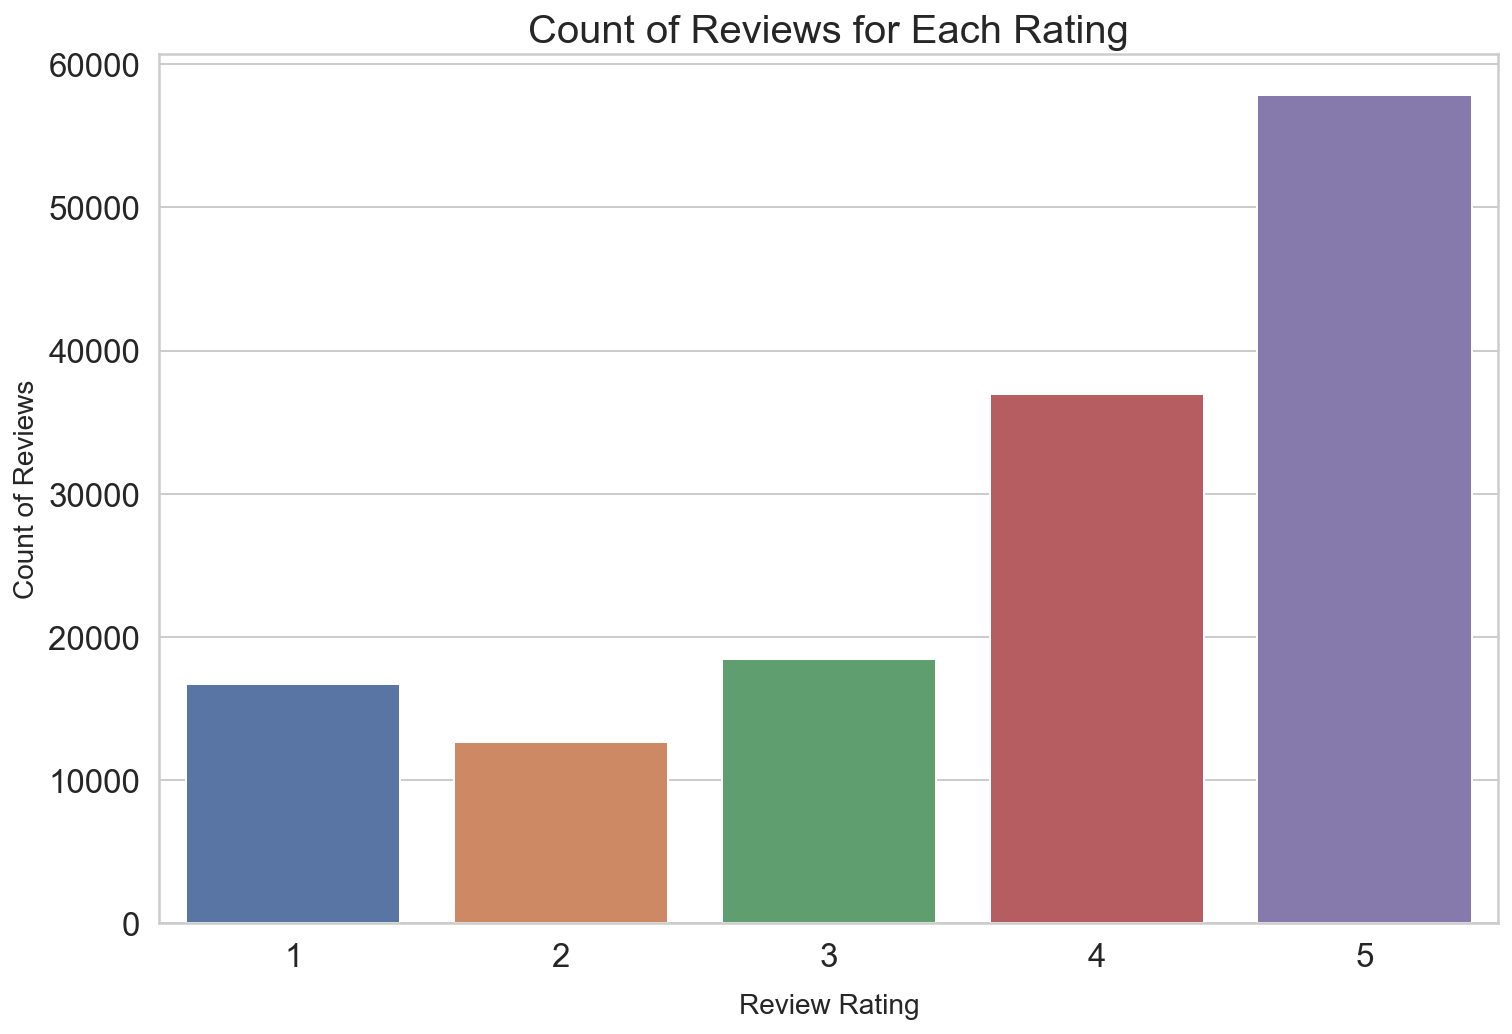

In [11]:
# plot distribution of review rating 
plt.figure(figsize = (12,8))
star_count = yelp['review_stars'].value_counts().sort_index()
sns.barplot(star_count.index,
            star_count.values)
plt.title('Count of Reviews for Each Rating',
          fontsize = 20)
plt.xlabel('Review Rating',
           labelpad = 10,
           fontsize = 14)
plt.ylabel('Count of Reviews',
           fontsize = 14)

In [12]:
yelp.groupby('review_stars')['text length'].mean()

review_stars
1    654.764100
2    711.851438
3    692.205301
4    602.679258
5    461.370781
Name: text length, dtype: float64

Text(0, 0.5, 'Average Length')

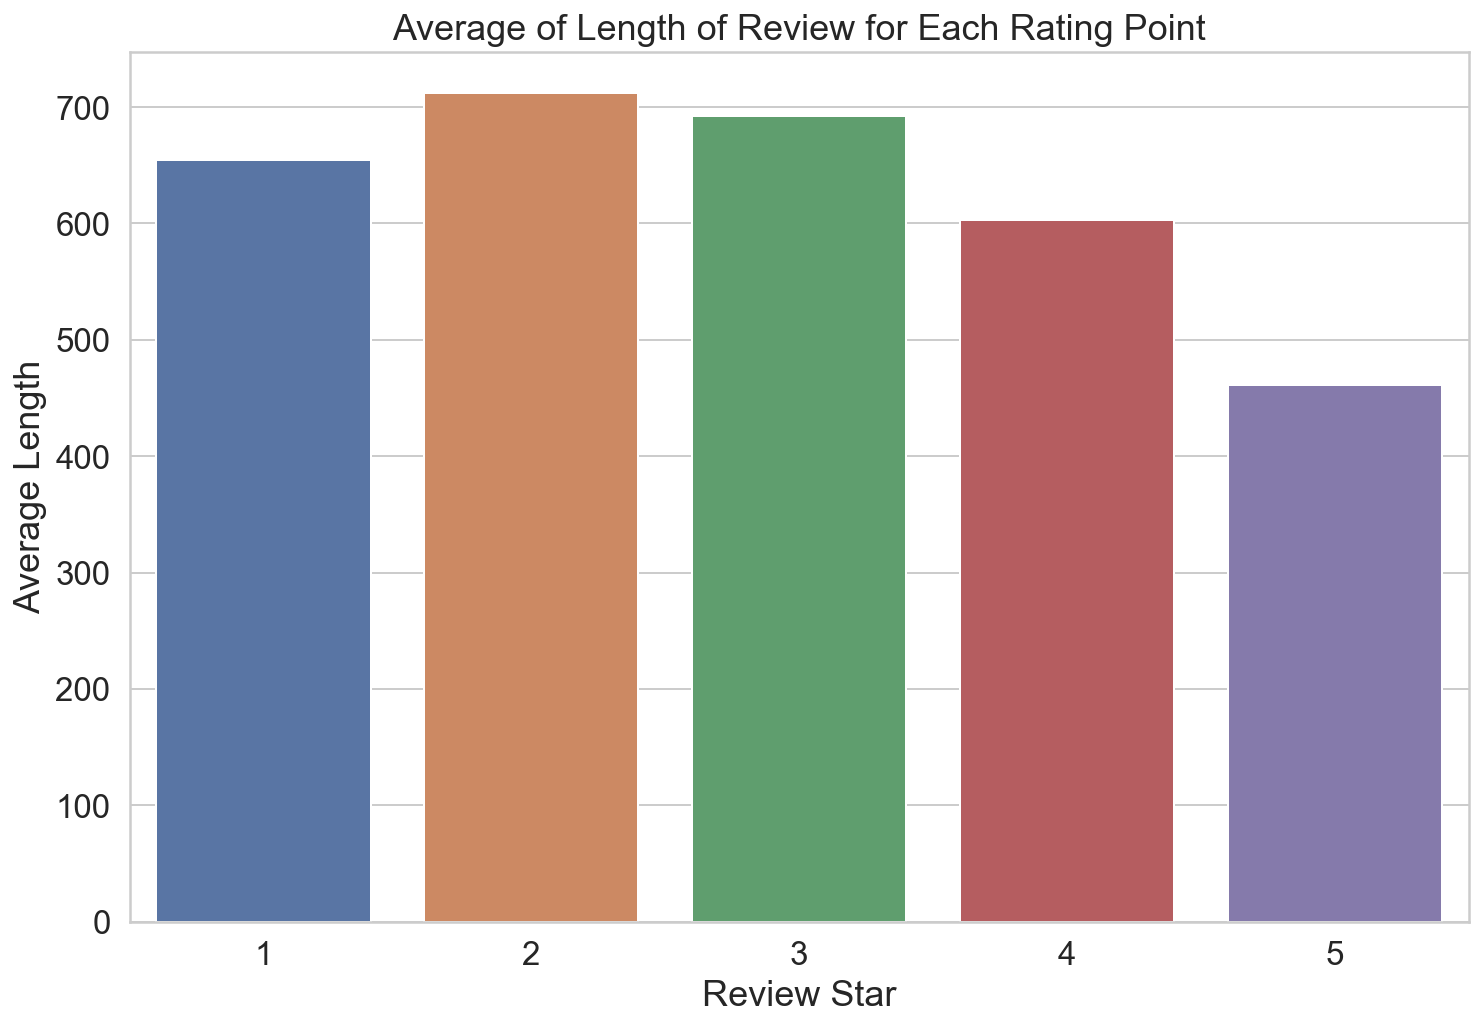

In [13]:
#comparing the distribution of the length of text for each rating point (number of characters)
plt.figure(figsize = (12, 8))
mean_len = yelp.groupby('review_stars')['text length'].mean()
sns.barplot(mean_len.index, mean_len.values)
plt.title('Average of Length of Review for Each Rating Point')
plt.xlabel('Review Star')
plt.ylabel('Average Length')

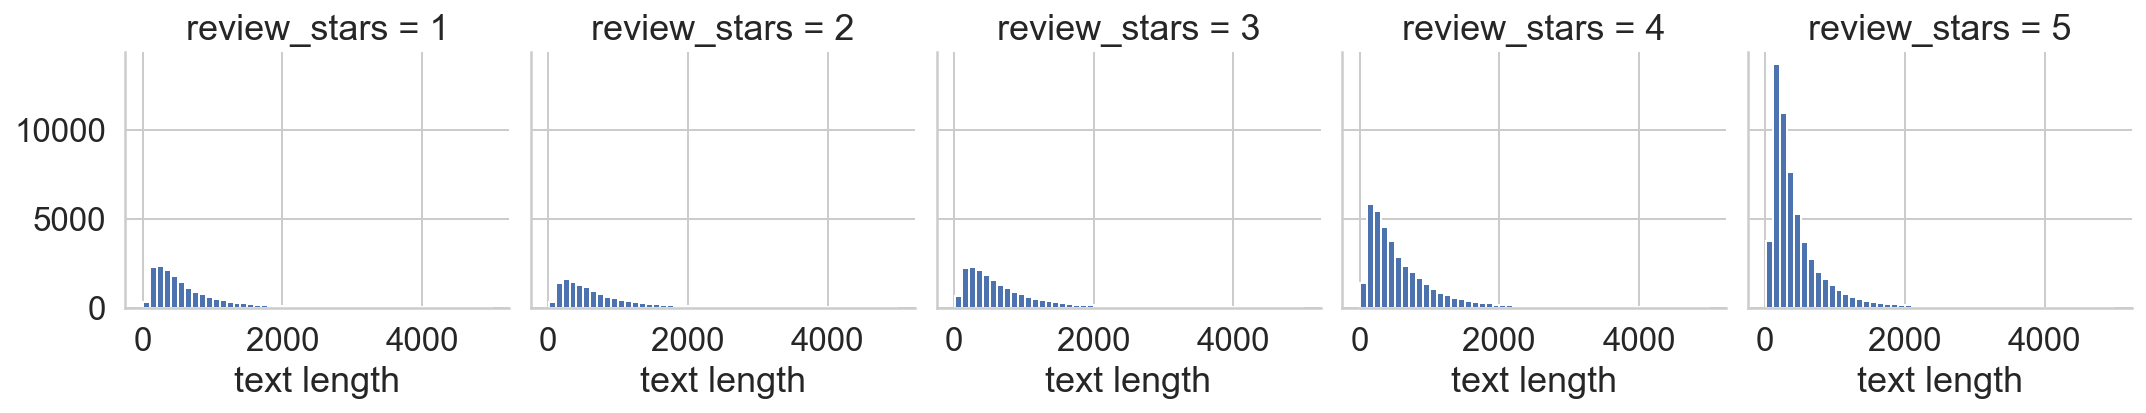

In [14]:
g = sns.FacetGrid(data = yelp, col='review_stars')
g.map(plt.hist, 'text length', bins = 50)

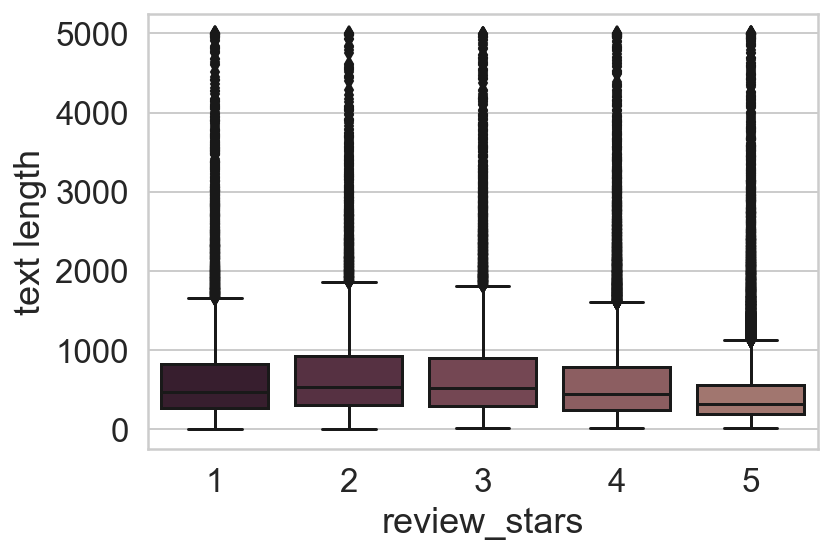

In [15]:
sns.boxplot(x = 'review_stars',
            y = 'text length',
            data = yelp,
            palette = sns.cubehelix_palette(9,
                                            start = .4,
                                            reverse = True,))

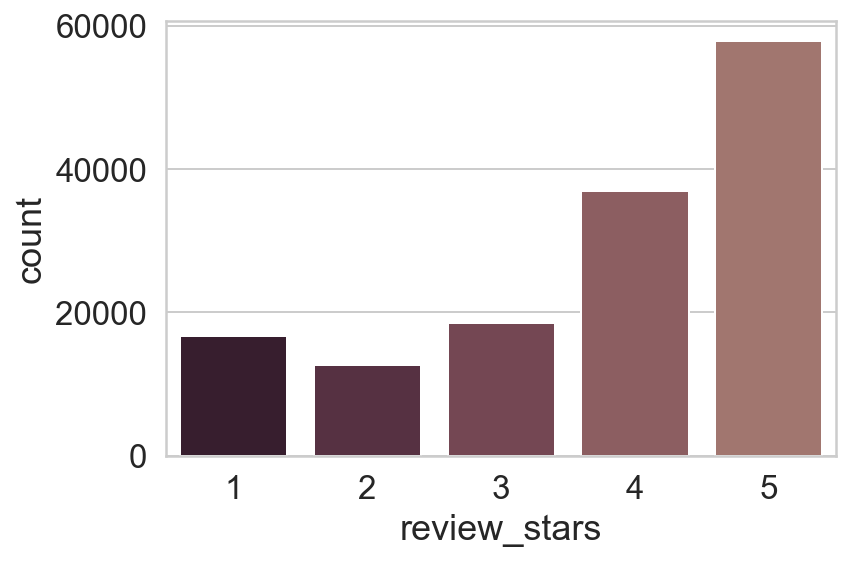

In [16]:
sns.countplot(x = 'review_stars',
              data = yelp,
              palette = sns.cubehelix_palette(9,
                                              start = .4,
                                              reverse = True))

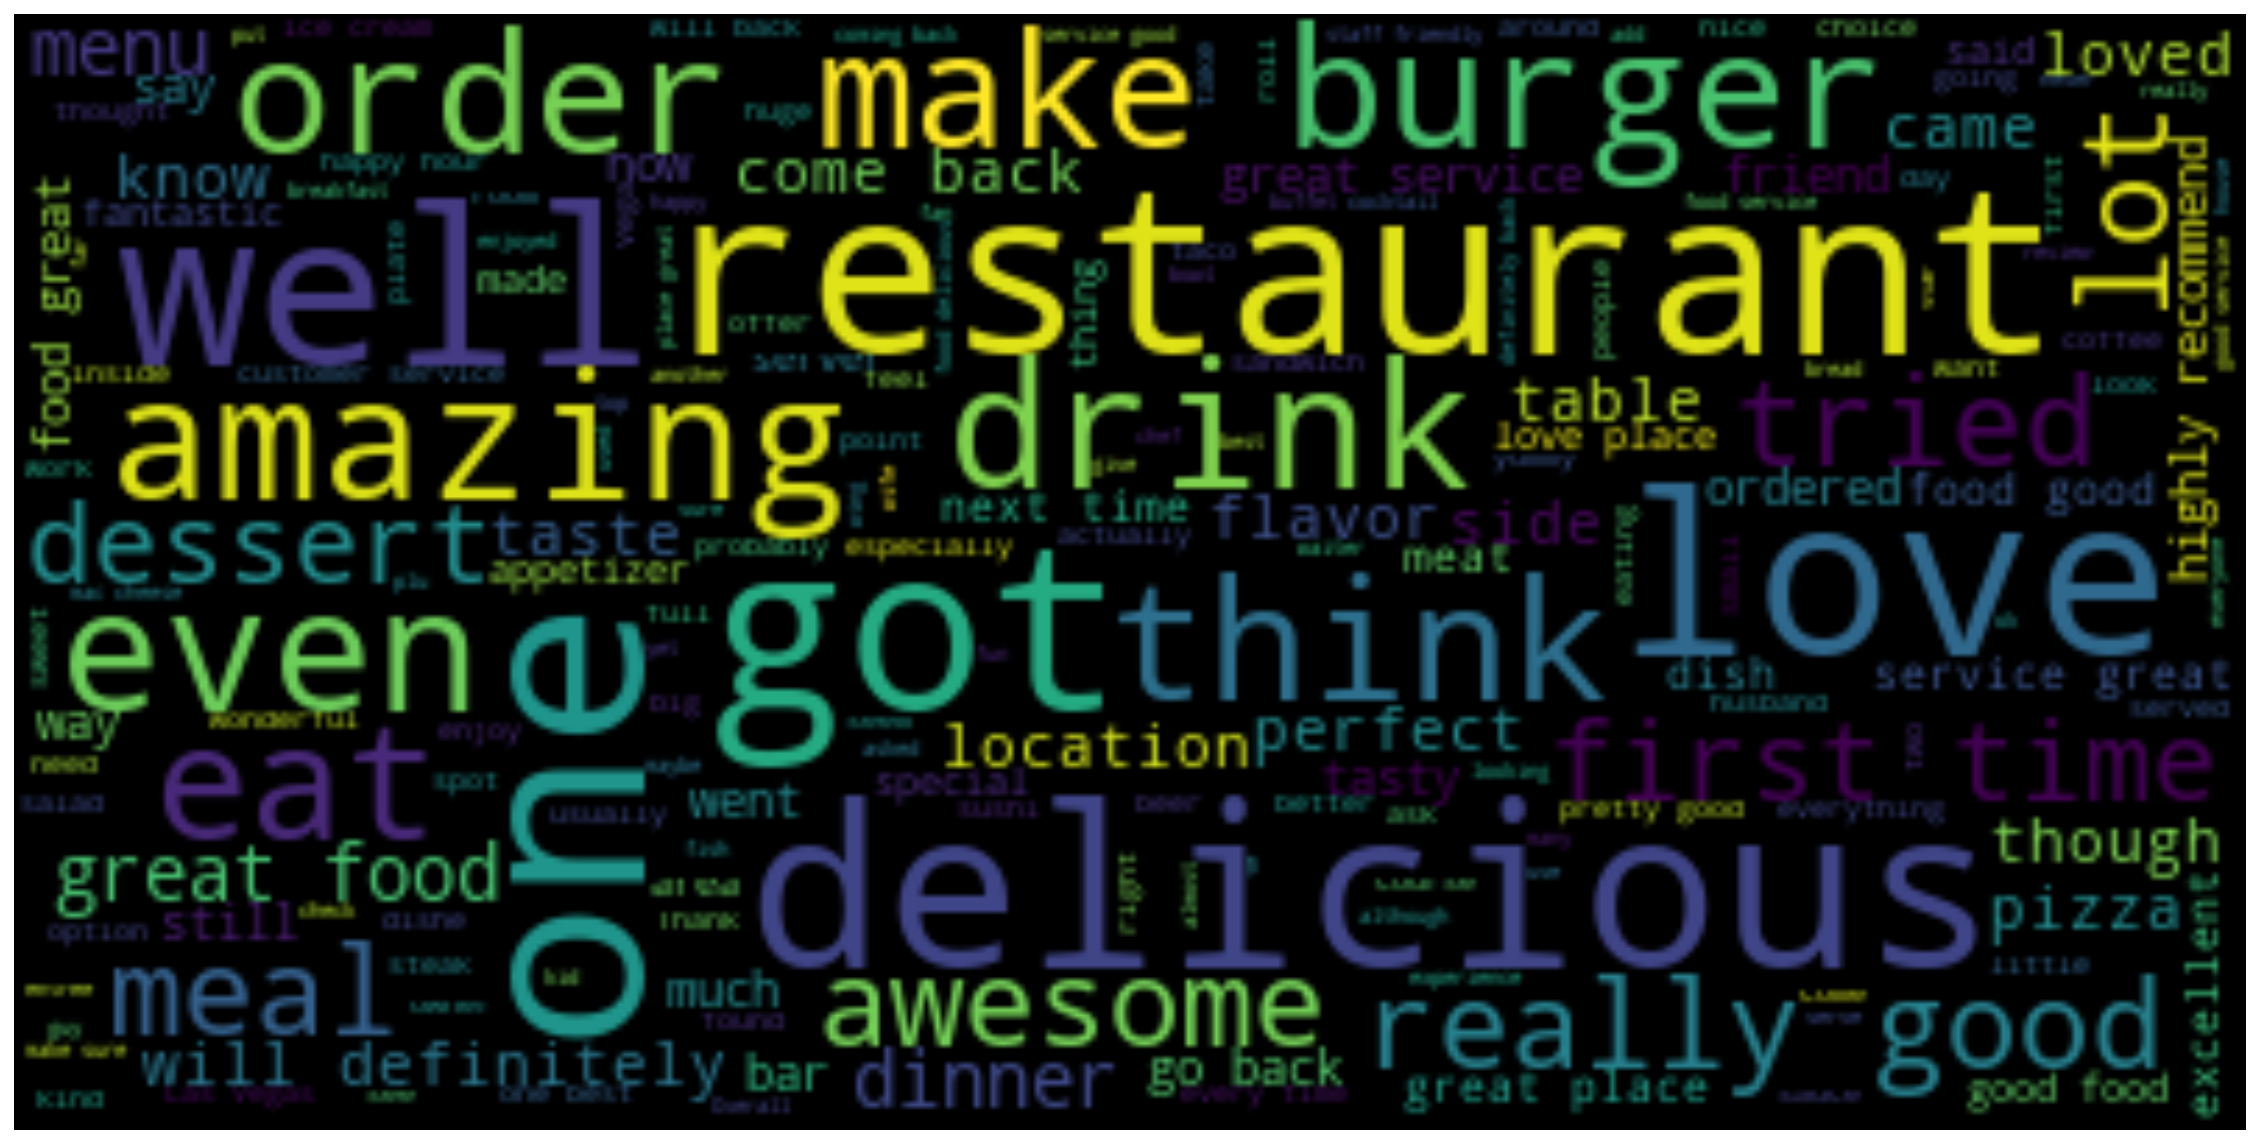

In [17]:

good_review_filter = ' '.join(
    yelp[yelp['review_stars'] == 5]['text']) + ' '.join(
    yelp[yelp['review_stars'] == 4]['text'])

# Adjust the size of image, make it look better, better to see the words.
wordcloud = WordCloud(max_font_size = 45).generate(good_review_filter)
plt.figure(figsize = (20, 16))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

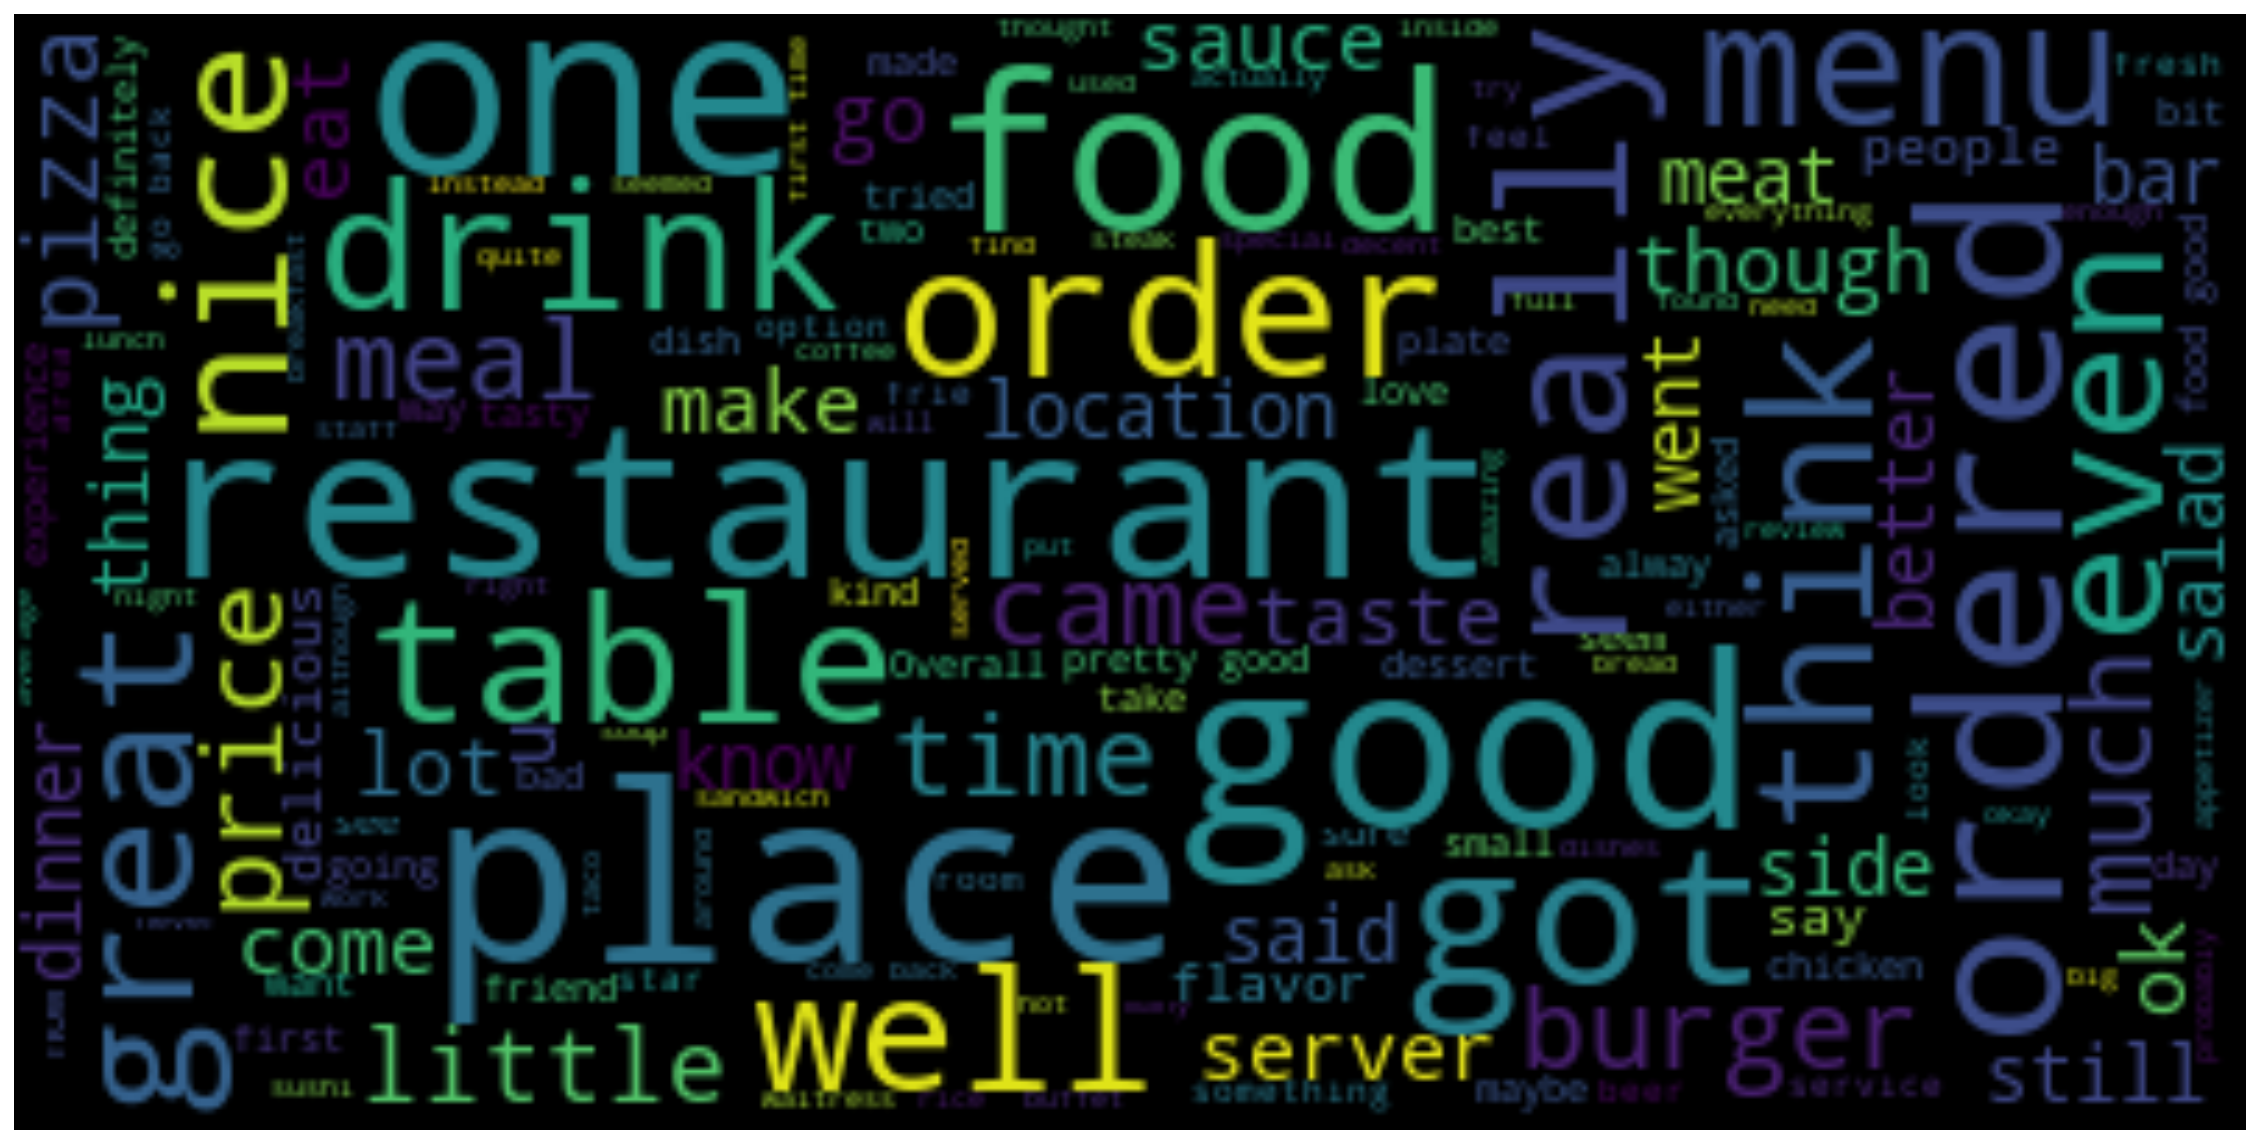

In [18]:
neutral_review_filter = ' '.join(yelp[yelp['review_stars'] == 3]['text'])

# Adjust the size of image, make it look better, better to see the words.
wordcloud = WordCloud(max_font_size = 45).generate(neutral_review_filter)
plt.figure(figsize = (20, 16))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

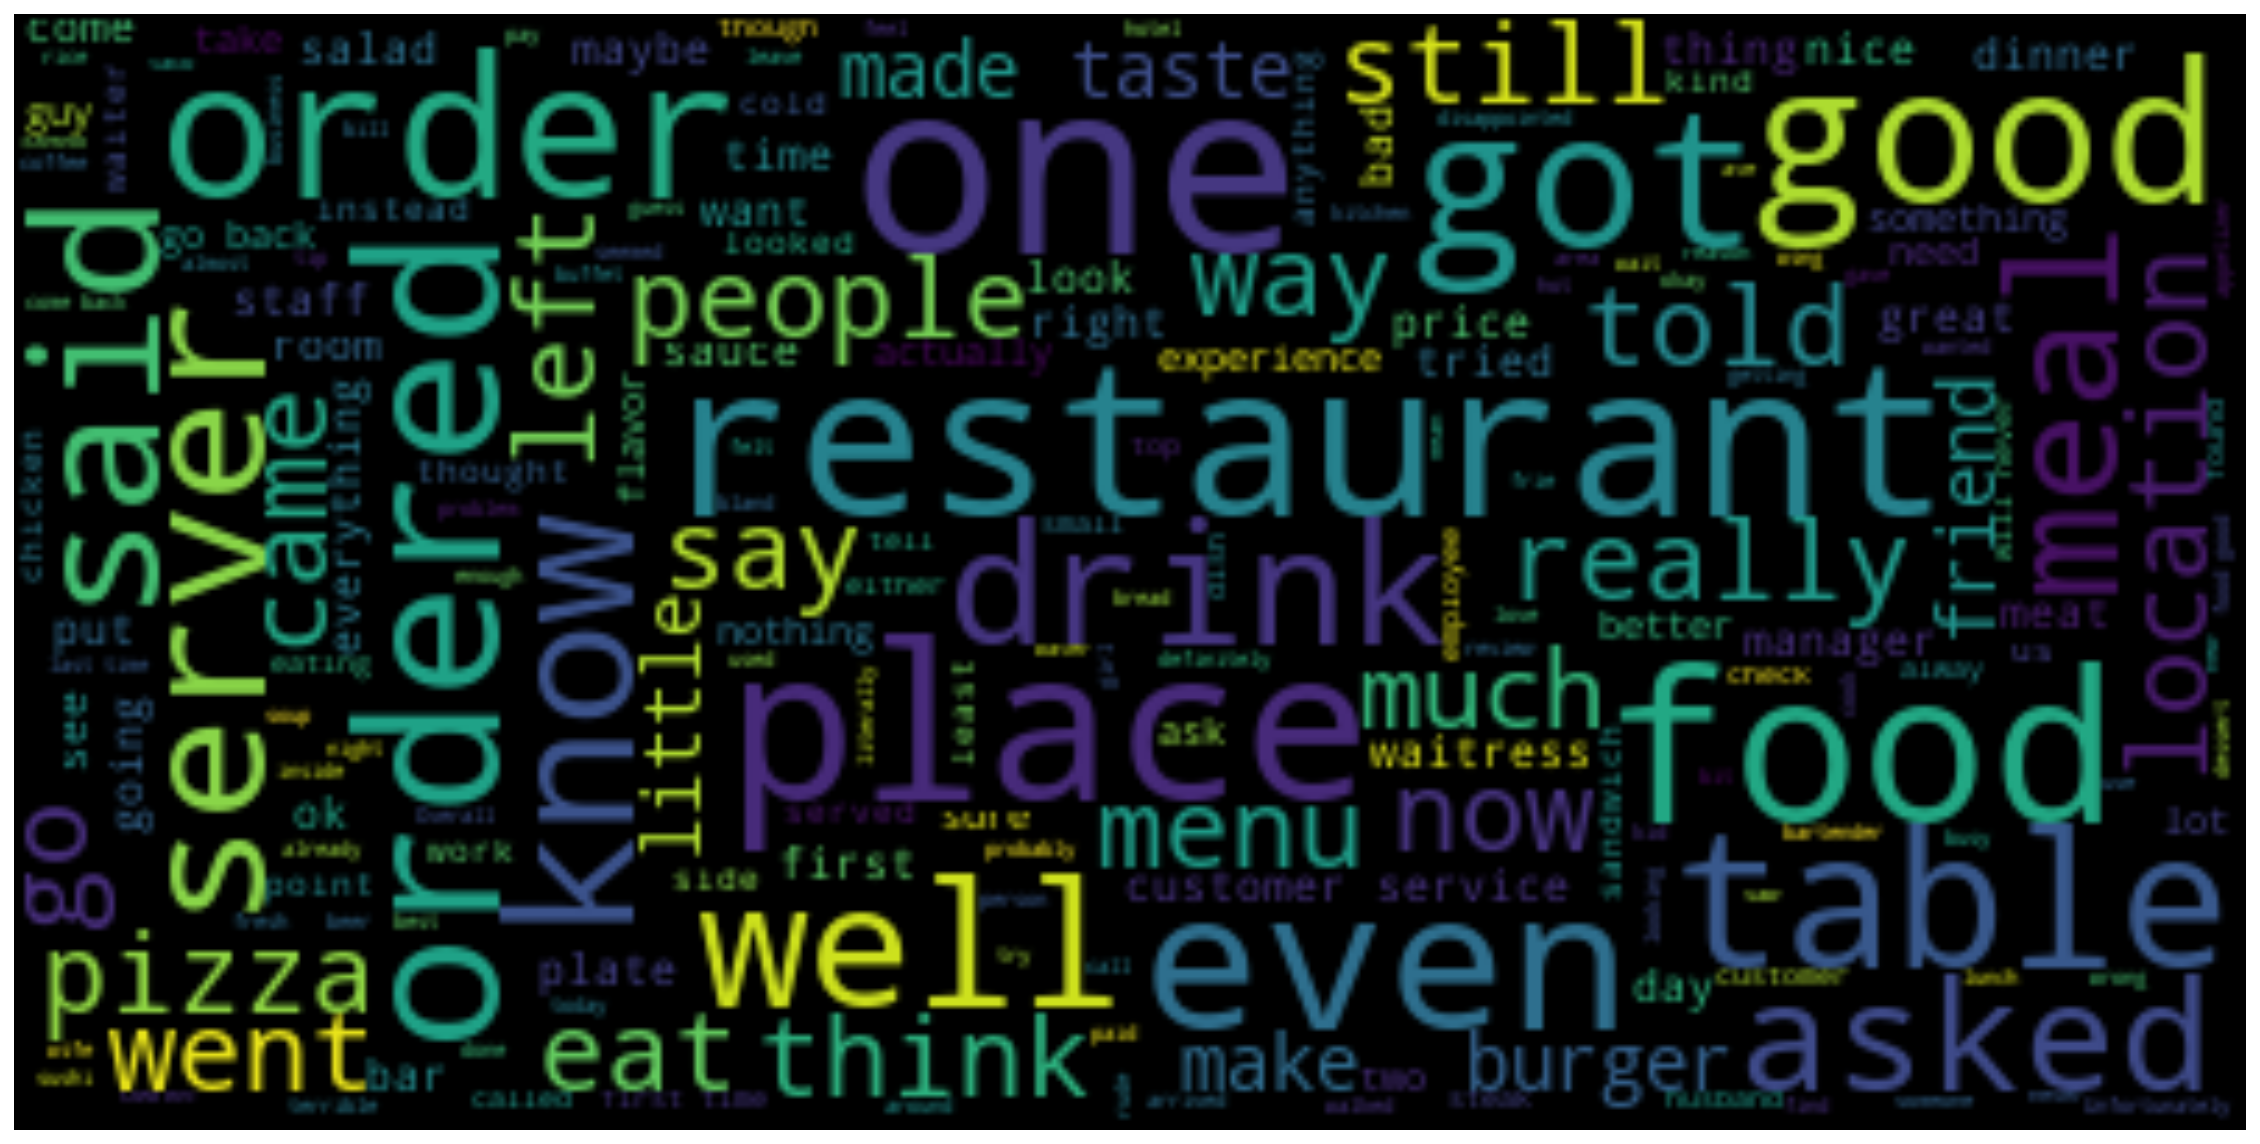

In [19]:
bad_review_filter = ' '.join(
    yelp[yelp['review_stars'] == 1]['text']) + ' '.join(
    yelp[yelp['review_stars'] == 2]['text'])

# Adjust the size of image, make it look better, better to see the words.
wordcloud = WordCloud(max_font_size = 45).generate(bad_review_filter)
plt.figure(figsize = (20, 16))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

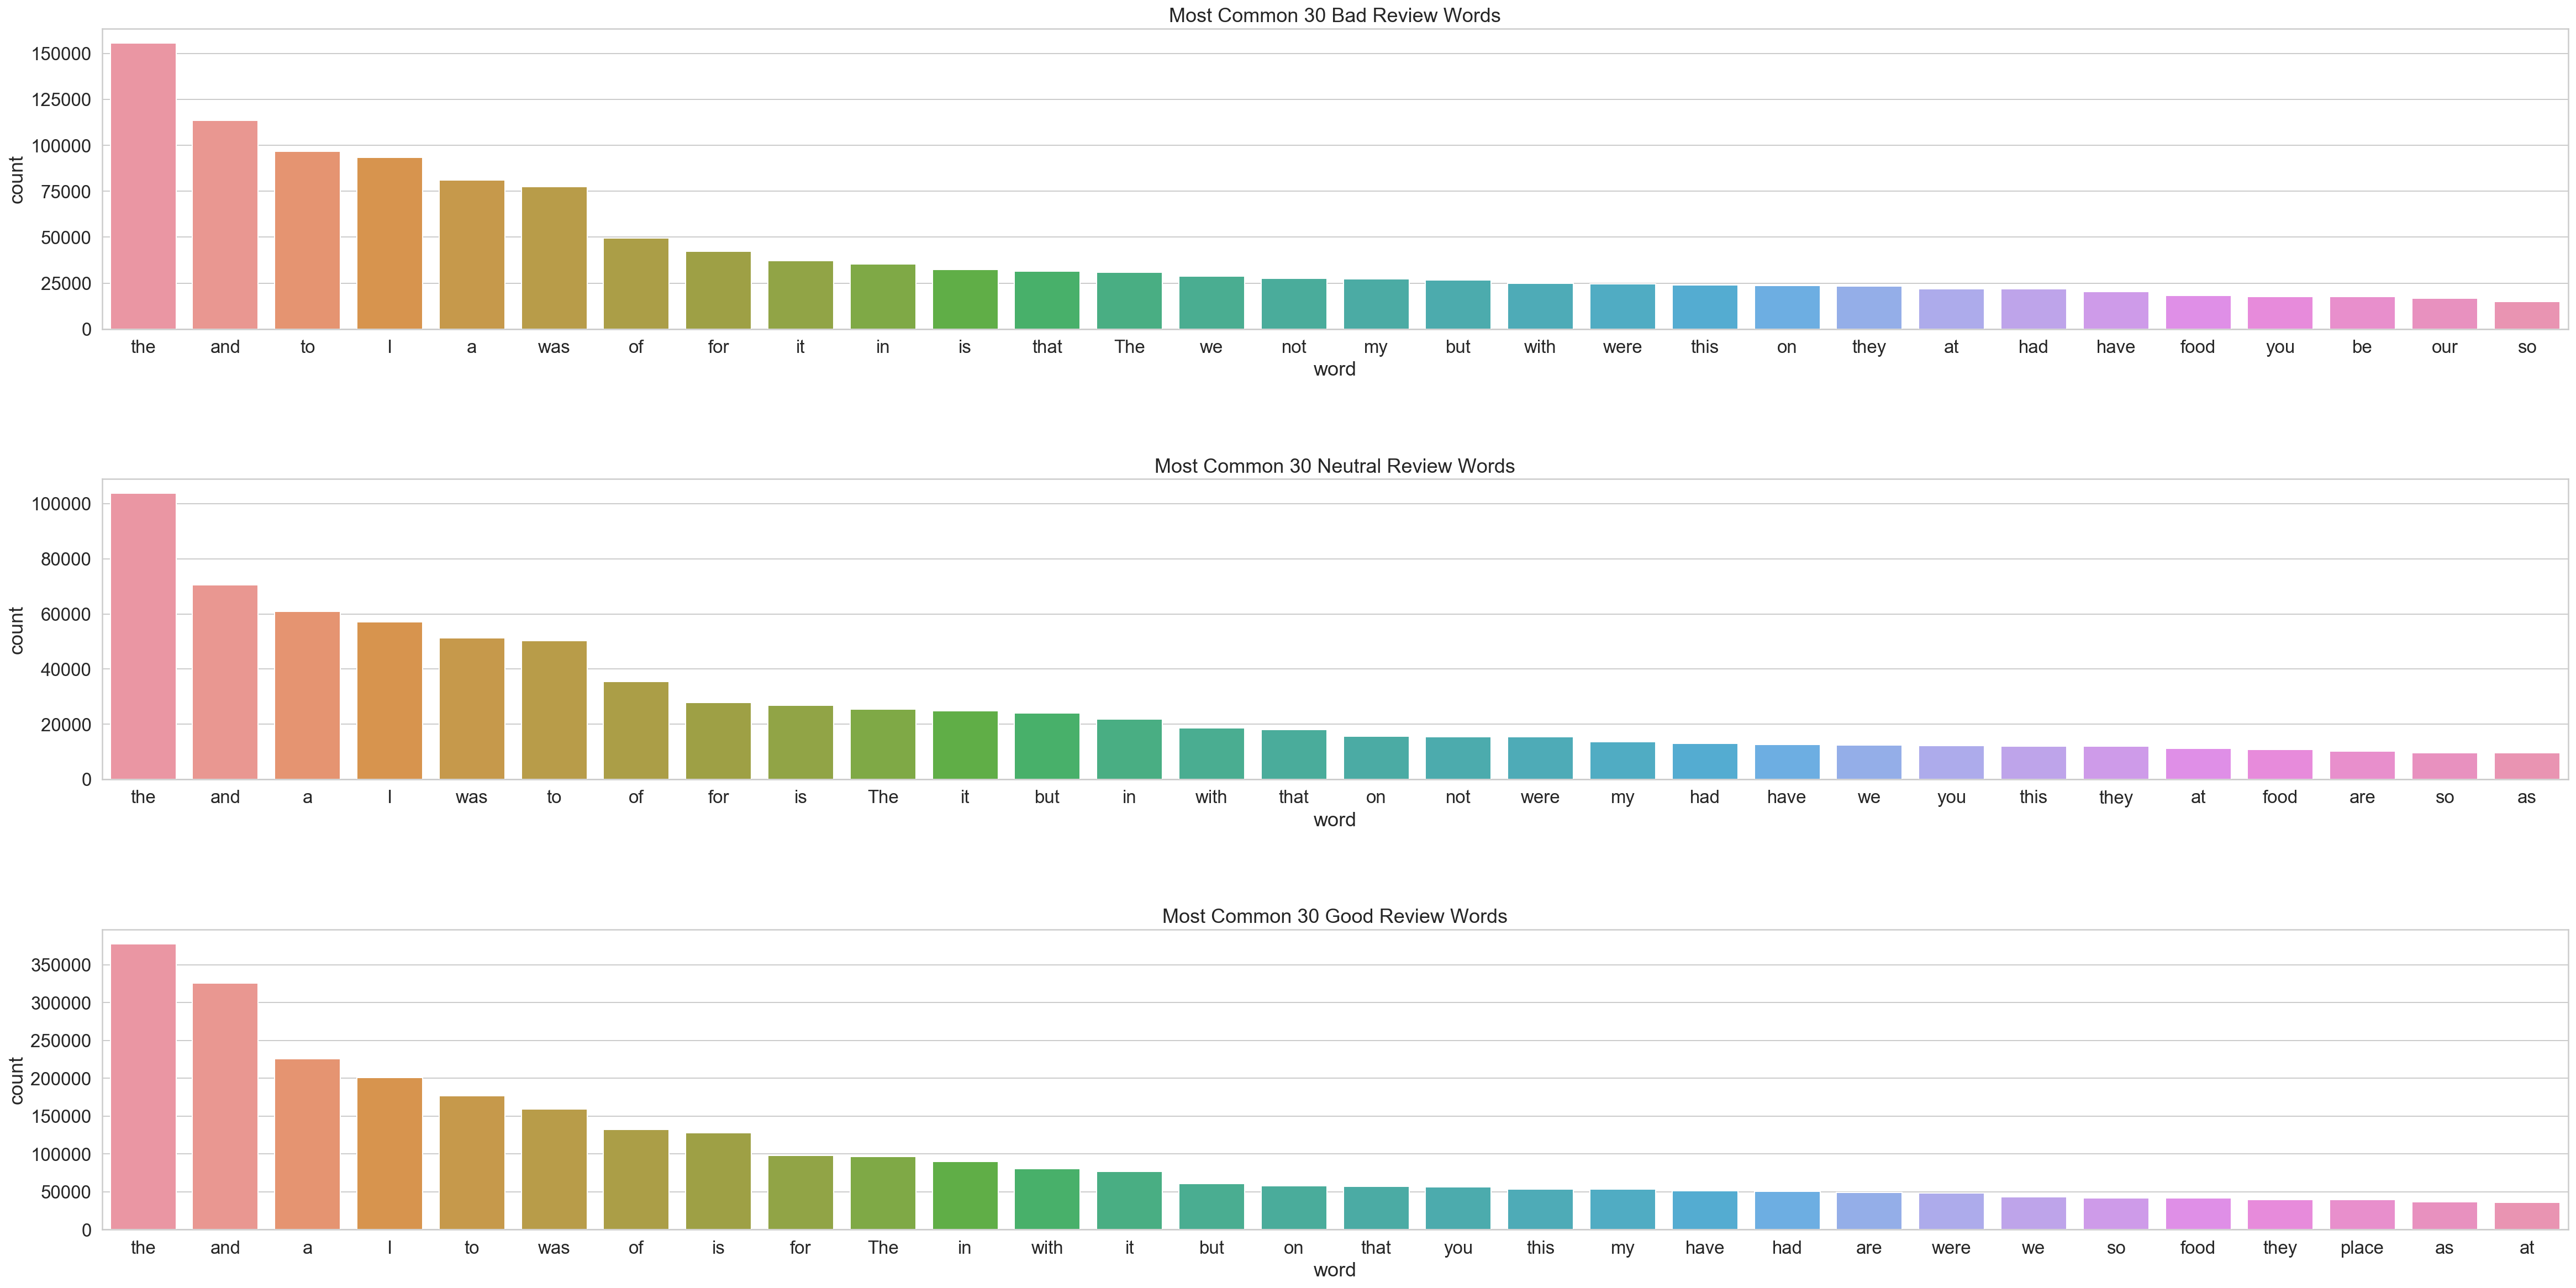

In [20]:
# The below charts are bar plot of the most 30 common words/puncs in each type of review. 
# The distribution looks pretty much the same, they have many words/puncs in common. I don't think this will be the
# best feature to use.

#get most common 30 bad, good, and neutral words

thirty_most_common_bad_words = dict(
    Counter((" ".join(
        yelp[yelp['review_stars'] == 1.0]['text']) + " ".join(
        yelp[yelp['review_stars'] == 2.0]['text'])).split()).most_common(30))
thirty_most_common_good_words = dict(
    Counter((" ".join(
        yelp[yelp['review_stars'] == 4.0]['text']) + " ".join(
        yelp[yelp['review_stars'] == 5.0]['text'])).split()).most_common(30))

thirty_most_common_neutral_words = dict(
    Counter(" ".join(
        yelp[yelp['review_stars'] == 3.0]['text']).split()).most_common(30))

num_bad, num_good, num_neutral = pd.Series(
    thirty_most_common_bad_words, name = 'count'), pd.Series(
    thirty_most_common_good_words, name = 'count'), pd.Series(
    thirty_most_common_neutral_words, name = 'count')

num_bad.index.name, num_good.index.name, num_neutral.index.name  = 'word', 'word', 'word'
num_bad, num_good, num_neutral = num_bad.reset_index(), num_good.reset_index(), num_neutral.reset_index()

# Make width large so words do not overlap
fig = plt.figure(figsize = (40, 20))

star_bad = fig.add_subplot(311) 
star_neutral = fig.add_subplot(312)
star_good = fig.add_subplot(313) 

sns.barplot(x = num_bad['word'],
            y = num_bad['count'],
            data = num_bad,
            ax = star_bad)
star_bad.set_title('Most Common 30 Bad Review Words')

fig.subplots_adjust(hspace = 0.5)

sns.barplot(x = num_neutral['word'],
            y = num_neutral['count'],
            data = num_neutral,
            ax = star_neutral)
star_neutral.set_title('Most Common 30 Neutral Review Words')

fig.subplots_adjust(hspace = 0.5)

sns.barplot(x = num_good['word'],
            y = num_good['count'],
            data = num_good,
            ax = star_good)
star_good.set_title('Most Common 30 Good Review Words')
plt.show()

In [21]:
def words_in_texts(words, texts):
    indicator_array = [int(
        letter in i) for i in texts for letter in words]
    indicator_array = np.array(
        np.array_split(
            np.array(
                indicator_array),
            len(texts)))
    return indicator_array

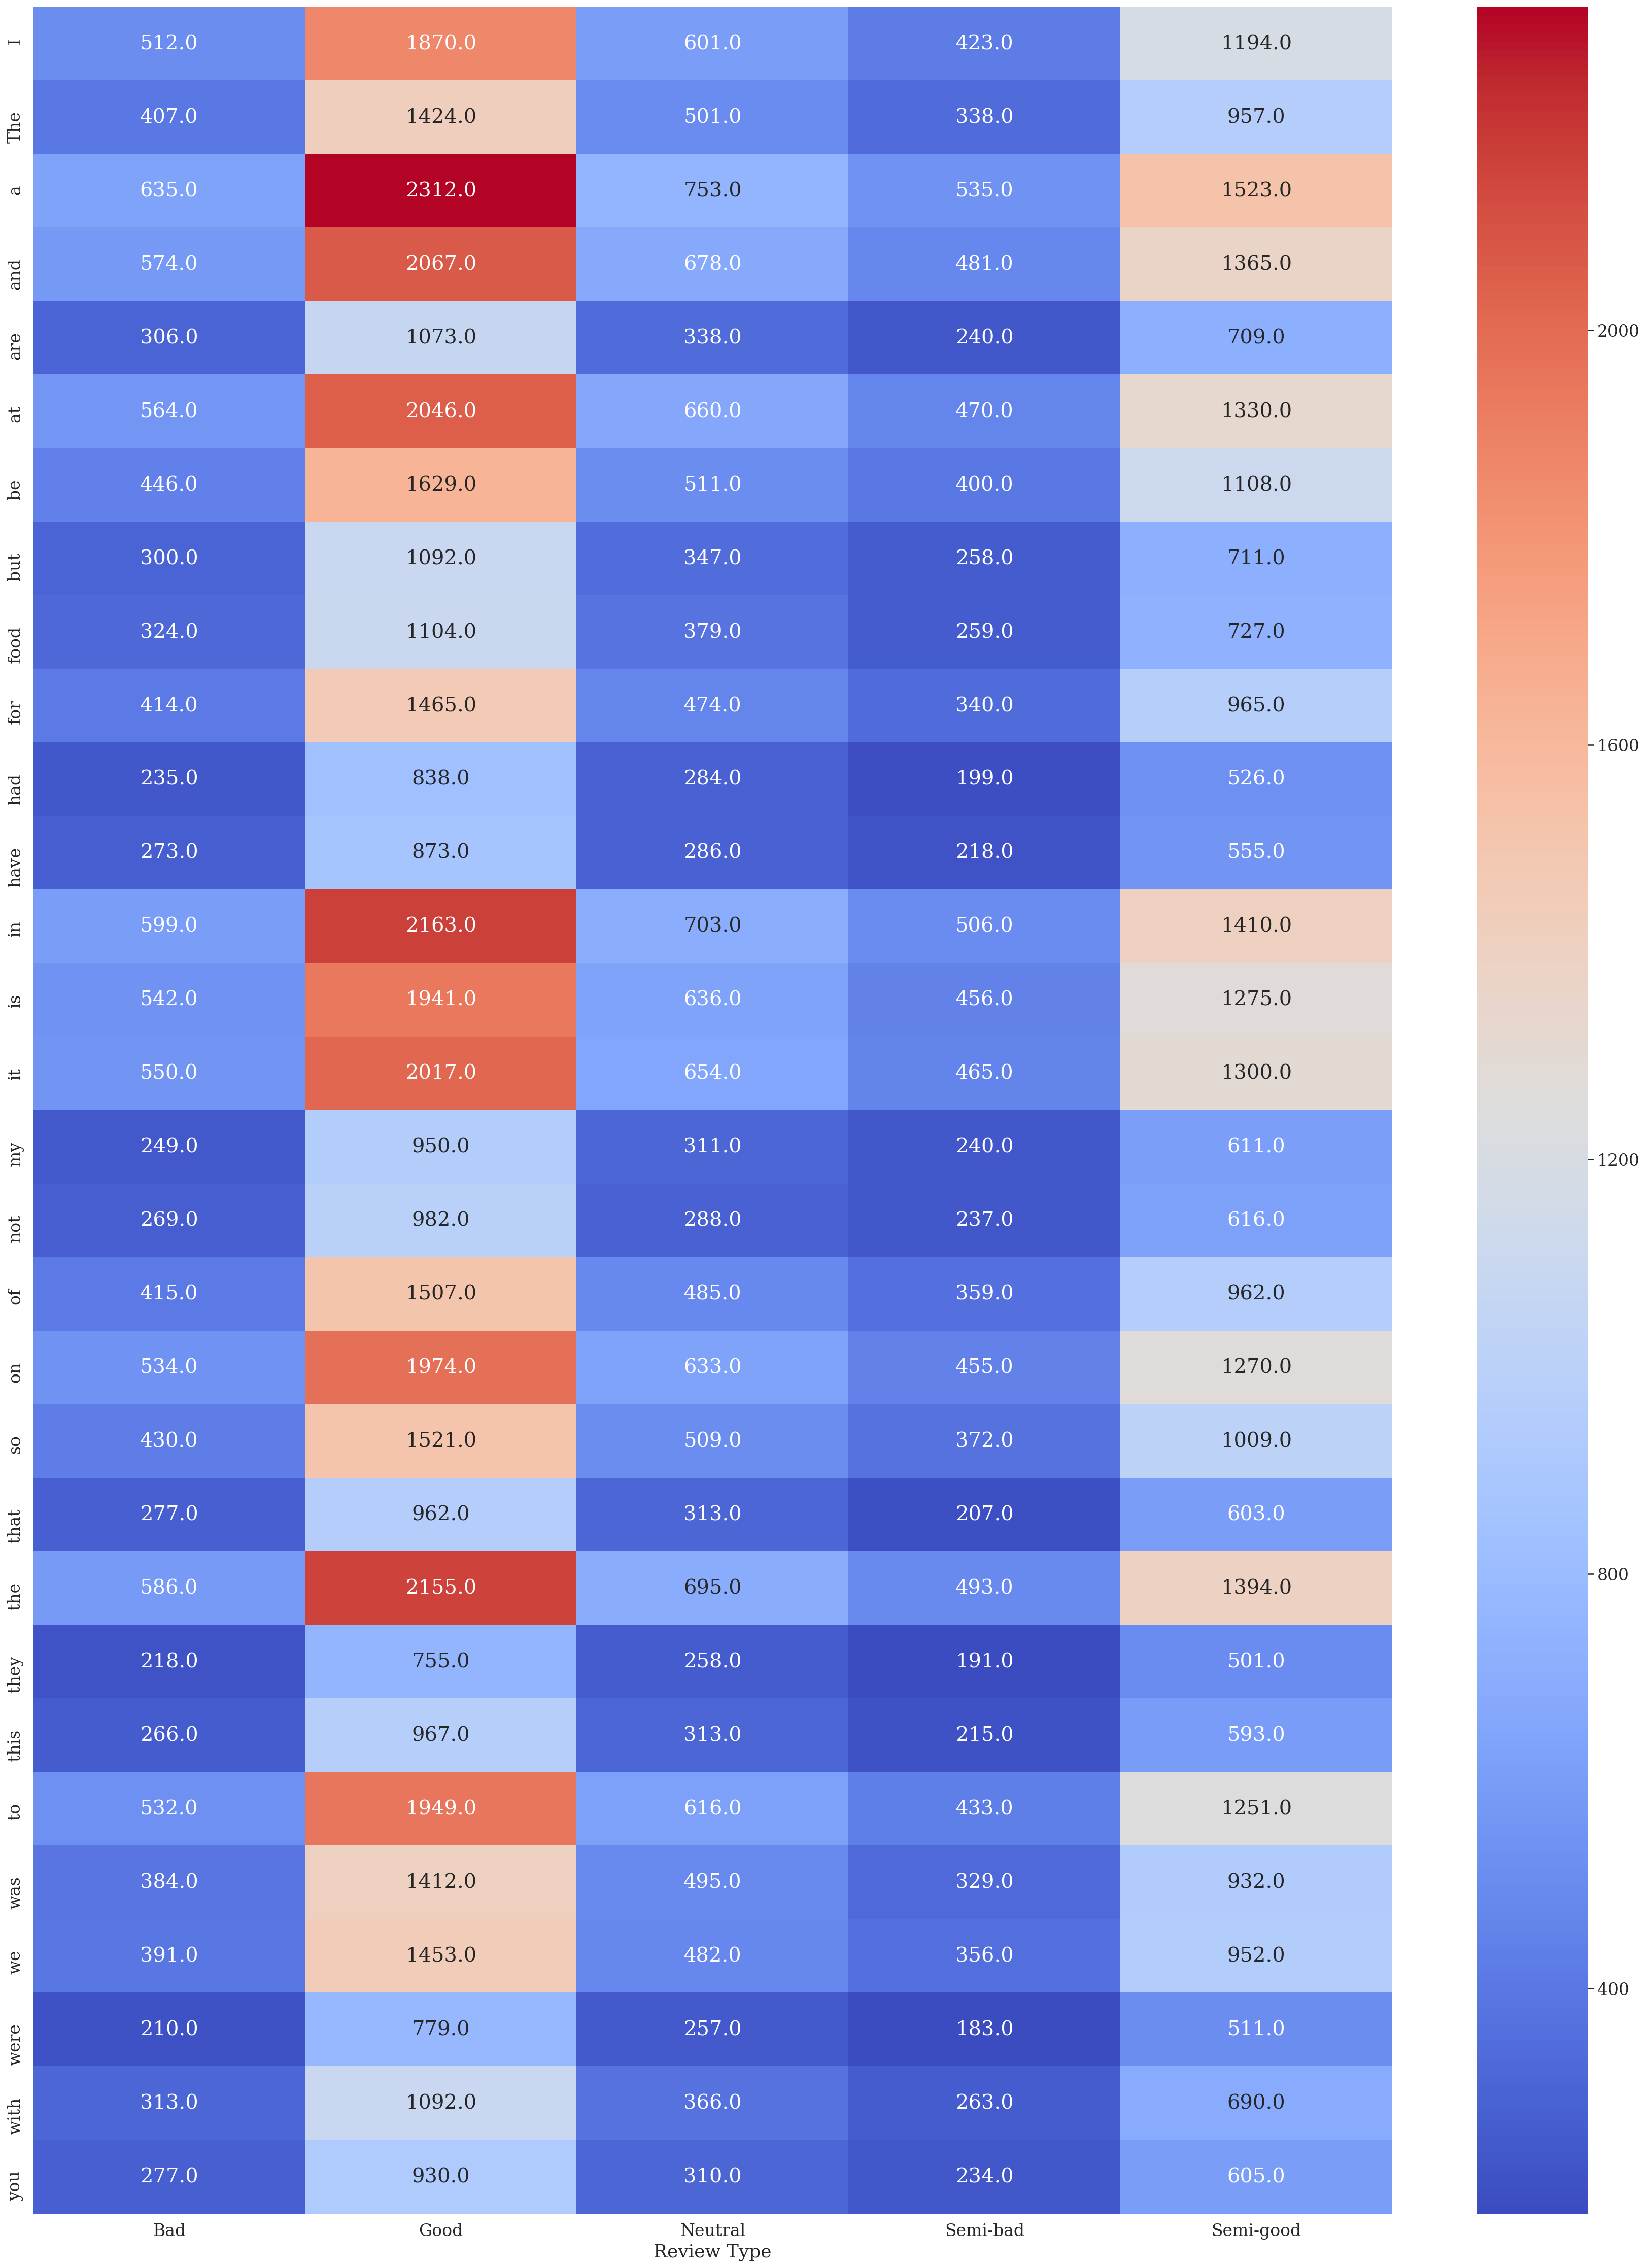

In [22]:
# Write the code to generate your visualization here:
most_common_words = dict(
    Counter(" ".join(yelp['text']).split()).most_common(30))

heatmap = pd.DataFrame(
    data = words_in_texts(list(most_common_words), yelp['text']), 
    columns = list(most_common_words))

heatmap['Review Type'] = yelp['review_stars']

prepare_heat_map_data = (heatmap.replace(
    {'Review Type': {
        1.0 : 'Bad', 
        5.0 : 'Good',
        3.0 : 'Neutral',
        4.0 : 'Semi-good',
        2.0 : 'Semi-bad'}}))

heat_map_data = prepare_heat_map_data.groupby('Review Type').sum()
final_table = pd.pivot_table(data = heat_map_data,
                    columns = 'Review Type')
plt.rcParams['figure.figsize'] = (30.0, 40)
plt.rcParams['font.family'] = "serif"
sns.heatmap(final_table, cmap = 'coolwarm', annot = True, fmt=".1f",annot_kws = {'size':20})

In [23]:
stars = yelp.groupby('review_stars').mean()
stars

cool    useful     funny  text length
review_stars                                           
1             0.205185  1.203568  0.547599   654.764100
2             0.352895  1.233950  0.548011   711.851438
3             0.622351  1.201669  0.530269   692.205301
4             0.775654  1.181921  0.477895   602.679258
5             0.536860  0.865577  0.304841   461.370781

In [24]:
stars = yelp.groupby('review_stars').mean()
stars

cool    useful     funny  text length
review_stars                                           
1             0.205185  1.203568  0.547599   654.764100
2             0.352895  1.233950  0.548011   711.851438
3             0.622351  1.201669  0.530269   692.205301
4             0.775654  1.181921  0.477895   602.679258
5             0.536860  0.865577  0.304841   461.370781

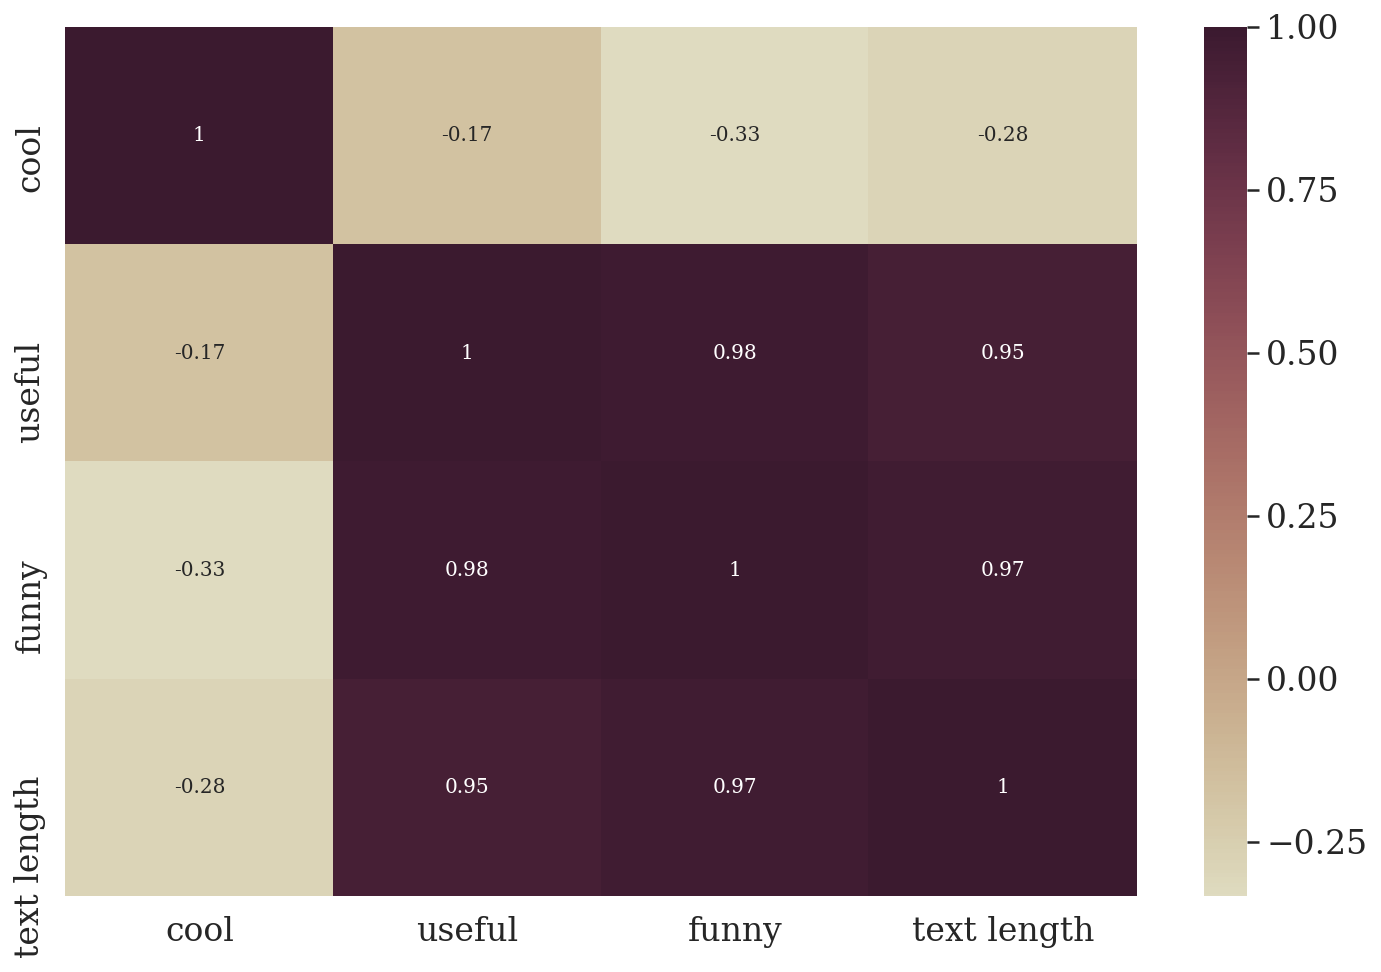

In [25]:
fig = plt.figure(figsize = (12,8))
cmap = sns.cubehelix_palette(9,
                             start = .4,
                             as_cmap = True,
                             reverse = False,
                             )
sns.heatmap(data = stars.corr(),
            annot = True,
            cmap = cmap)

# Testing Model:

## NB Pipeline

In [26]:
clean_yelp.shape

(3566763, 7)

In [28]:
getting_sample = clean_yelp.sample(n = 400000, random_state = 42)
train_sample = getting_sample[0: 300000]
test_sample = getting_sample[300000:]
train_sample = train_sample[['text', 'review_stars']]
train_sample = pd.get_dummies(train_sample, columns = ['review_stars'])
test_sample = test_sample[['text', 'review_stars']]
test_sample = pd.get_dummies(test_sample, columns = ['review_stars'])
train_sample_to_test = train_sample.sample(frac = .05, random_state = 42)
test_samp_to_test = test_sample.sample(frac = .1, random_state = 42)
tfidf = TfidfVectorizer(max_features = 2000)

In [29]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def transform(self, x):
        return self.preprocess_x(x, self._r)

    def preprocess_x(self, first, second):
        return first.multiply(second)

    def pr(self, x, y_i, y):
        return (x[y == y_i].sum(0) + self.alpha) / ((y == y_i).sum() + self.alpha)

    def fit(self, x, y=None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) / self.pr(x, 0, y)))
        return self

In [30]:
logisticregression = LogisticRegression(solver = 'lbfgs')
nb = NBFeatures(1)
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', logisticregression)
])

In [31]:
star_type = ['review_stars_1',
               'review_stars_2',
               'review_stars_3',
               'review_stars_4',
               'review_stars_5']

recorded_scores = 0
predict = np.zeros((len(test_samp_to_test),
                    len(star_type)))
counter = 0
for index, star_type in enumerate(star_type):
    cv_score = np.mean(cross_val_score(estimator = pipeline,
                                       X = train_sample_to_test['text'].values, 
                                       y = train_sample_to_test[star_type].values,
                                       cv = 3,
                                       scoring = 'accuracy'))
    recorded_scores += cv_score
    print('Accuracy rate for class {} is {}'.format(star_type,
                                                    cv_score))
    pipeline.fit(train_sample_to_test['text'].values,
                 train_sample_to_test[star_type].values)
    predict[:, index] = pipeline.predict_proba(test_samp_to_test['text'].values)[:, 1]
    counter += 1
score_pineline = recorded_scores / counter
print('The average accuracy score is: ', score_pineline)

Accuracy rate for class review_stars_1 is 0.9221338645920213
Accuracy rate for class review_stars_2 is 0.9130667443466698
Accuracy rate for class review_stars_3 is 0.8734000000000001
Accuracy rate for class review_stars_4 is 0.7435333531680008
Accuracy rate for class review_stars_5 is 0.7919991144426312
The average accuracy score is:  0.8488266153098646


In [121]:
one_star = yelp.loc[yelp['review_stars'] == 1.0]
two_star = yelp.loc[yelp['review_stars'] == 2.0]
three_star = yelp.loc[yelp['review_stars'] == 3.0]
four_star = yelp.loc[yelp['review_stars'] == 4.0]
five_star = yelp.loc[yelp['review_stars'] == 5.0]

In [133]:
yelp_class = subset_data = pd.concat([one_star.sample(n =12000, random_state = 1),
                        two_star.sample(n=12000, random_state = 1),
                        three_star.sample(n=12000, random_state = 1), 
                        four_star.sample(n=12000, random_state = 1),
                        five_star.sample(n=12000, random_state = 1)])
yelp_class.shape

(60000, 7)

In [134]:
yelp_class = yelp_class[['review_stars', 'text']]

In [135]:
yelp_class = yelp_class.sample(frac = .1, random_state = 42)

In [136]:
yelp_class.shape

(6000, 2)

In [137]:
X = yelp_class['text']
y = yelp_class['review_stars']

In [138]:
def text_processing(text):
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

In [139]:
transformer = CountVectorizer(analyzer = text_processing).fit(X)

In [140]:
X = transformer.transform(X)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [142]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [143]:
predict = nb.predict(X_test)

In [145]:
pipeline_model = Pipeline([
    ('bow',
     CountVectorizer(analyzer = text_processing)),
    ('classifier',
     MultinomialNB())
])

In [146]:
X = yelp_class['text']
y = yelp_class['review_stars']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [147]:
pipeline_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x000001E9DA808678>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [148]:
predict = pipeline_model.predict(X_test)

In [154]:
input_text = input("Enter Review: ")
input_text = [input_text]
input_text = pd.DataFrame(input_text, columns = ['a'])
print('The predicted rating stars based on entered review is:', pipeline_model.predict(input_text['a']))

Enter Review: not too good, but not too bad
The predicted rating stars based on entered review is: [3]


## TF-IDF (Term Frequency- Inverse Document Frequency)

In [155]:
review_business_sample.head()

all_reviews  review_count  stars
0  I've only had the chance to go there once or t...             5    4.0
1  All I ask for in a Chicago style thin crust is...            18    3.5
2  Fab falafal! I found the experience here so ov...           145    3.5
3  The restaurant is now a pizza joint.  I called...             3    3.5
4  Sorry Dairy Queen. I visited this location whe...             6    1.5

In [156]:
#we need to normalized the reviews since it has so many different values
review_count_normalized=zscore(review_business_sample['review_count'])
#normalizing review_count
review_count_normalized

array([-0.27693124, -0.14656167,  1.12704873, ...,  9.00939345,
       -0.12650482, -0.25687438])

In [157]:
#using tf-idf to do feature extraction from review contents for models. This help reflecting how important or essential
#a word or phrase is in a doc. This works because it represents the number of times that words appear.
vectorizer_TF_IDF = sk_text.TfidfVectorizer(stop_words = 'english',
                                     max_features = 1000,
                                     min_df = 2)
matrix = vectorizer_TF_IDF.fit_transform(review_business_sample['all_reviews'])
print(type(matrix))
print(matrix.toarray())

<class 'scipy.sparse.csr.csr_matrix'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.02344267 0.0100926  ... 0.01410567 0.00437178 0.0566116 ]
 ...
 [0.00720276 0.01392834 0.00277614 ... 0.001746   0.01370887 0.02865246]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [158]:
#Matrix to array
tfif_data = matrix.toarray()
#merge review_count and tfid_data arrays
concat_matrix = np.column_stack((tfif_data,
                                 review_count_normalized))
concat_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.76931241e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.46561672e-01],
       [ 0.00000000e+00,  2.34426702e-02,  1.00926045e-02, ...,
         4.37177811e-03,  5.66115956e-02,  1.12704873e+00],
       ...,
       [ 7.20276228e-03,  1.39283430e-02,  2.77614328e-03, ...,
         1.37088677e-02,  2.86524551e-02,  9.00939345e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.26504815e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.56874384e-01]])

In [159]:
#Shape of tfif_data array
tfif_data.shape

(11874, 1000)

### Linear Regression Model:


In [160]:
X_data = concat_matrix
Y_data = review_business_sample['stars']

#split data in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size = .25,
                                                    random_state = 42)

In [161]:
print(X_train.shape)
print(X_test.shape)

(8905, 1001)
(2969, 1001)


In [164]:
# using the default parameters
lr = LinearRegression()

# fit the model with data
lr.fit(X_train,y_train)

predict = lr.predict(X_test)

score = metrics.mean_squared_error(predict,
                                   y_test)
print("Mean squared error score (MSE): {}".format(score))

#print our RMSE error.
score_linear_regression = np.sqrt(metrics.mean_squared_error(predict,
                                                             y_test))
print("Accuracy rate: {}".format(score_linear_regression))

Mean squared error score (MSE): 0.29946177193987056
Accuracy rate: 0.5472310041836724


## Classification Models:

In [165]:
#do one hot encoding on stars column 
class_model = preprocessing.LabelEncoder()
class_model.fit(review_business_sample['stars'])

list(class_model.classes_)

Y = class_model.transform(review_business_sample['stars'])

In [166]:
X_data = concat_matrix
Y_data = Y

#split data in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size = .25,
                                                    random_state = 42)

### Support Vector Machine Model:

In [167]:
vector_machine = SVC()
vector_machine.fit(X_train,
        y_train)
y_predict = vector_machine.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [168]:
#Print out accuracy of support vector machine model
score_svm = vector_machine.score(X_test,
                                 y_test)
print('Accuracy rate: {:.2f}'.format(score_svm))

Accuracy rate: 0.19


### Nearest Neighbors Model:

In [169]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,
        y_train)
y_pred = knn.predict(X_test)

In [170]:
score_nnm = knn.score(X_test,
                      y_test)
print('Accuracy rate: {:.2f}'.format(score_nnm))

Accuracy rate: 0.29


### Logistic Regression Model:

In [171]:
# instantiate the model (using the default parameters)
logistic_regression = LogisticRegression()
# fit the model with data
logistic_regression.fit(X_train,
                        y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
y_predict = logistic_regression.predict(X_test)
score_logistic_regression = logistic_regression.score(X_test, y_test)
print('Accuracy rate: {:.2f}'.format(score_logistic_regression)) 

Accuracy rate: 0.39


### Min & Max Normalization

In [173]:
#Min & Max Normalization for MNB because Multionominal Naive Bayes does not take negative values like in 
#z-score normalization.
max_fac = review_business_sample['review_count'].max()
min_fac = review_business_sample['review_count'].min()
minmax =  max_fac - min_fac
count = review_business_sample['review_count'] - review_business_sample['review_count'].min()
MNNBayes_count = count / minmax
concat_matrix = np.column_stack((tfif_data,
                               MNNBayes_count.values))
X = concat_matrix

### Multi-Nominal Naive Bayes Model:

In [174]:
X_data = X
MNNBayes = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                Y_data,
                                                test_size = 0.25,
                                                random_state = 42)

In [175]:
#fit Multi-Nominal Naive Bayes Model
MNNBayes.fit(X_train, y_train)
y_predidct = MNNBayes.predict(X_test)

In [176]:
score_MNNBayes = MNNBayes.score(X_test, y_test)
print('Accuracy rate: {:.2f}'.format(score_MNNBayes))

Accuracy rate: 0.32


### Backend Tensorflow:

In [177]:
X_data = concat_matrix

tenflow = preprocessing.LabelEncoder()
tenflow.fit(review_business_sample['stars'])

list(tenflow.classes_)

Y_data = tenflow.transform(review_business_sample['stars'])

# Split data to train and test set
x_train, x_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size = 0.25,
                                                    random_state = 42)

### Tensorflow Regression:

In [180]:
tensorflow_regression = Sequential()

tensorflow_regression.add(Dense(25,
                                input_dim = X_data.shape[1],
                                activation = 'relu'))
tensorflow_regression.add(Dense(10,
                                activation = 'relu'))
tensorflow_regression.add(Dense(1))

tensorflow_regression.compile(loss = 'mean_squared_error',
                              optimizer = 'adam')

tensorflow_regression.fit(X_data,
                          Y_data,
                          verbose = 2,
                          epochs = 100)

predict = tensorflow_regression.predict(X_data)
print("Shape: {}".format(predict.shape))
print(predict)

# print out RMSE error.
score_tensorflow_regression = np.sqrt(metrics.mean_squared_error(predict, Y_data))
print("Accuracy rate: {}".format(score_tensorflow_regression))

Epoch 1/100
 - 0s - loss: 5.6614
Epoch 2/100
 - 0s - loss: 1.3481
Epoch 3/100
 - 0s - loss: 1.1163
Epoch 4/100
 - 0s - loss: 1.0217
Epoch 5/100
 - 0s - loss: 0.9263
Epoch 6/100
 - 0s - loss: 0.8181
Epoch 7/100
 - 0s - loss: 0.7259
Epoch 8/100
 - 0s - loss: 0.6505
Epoch 9/100
 - 0s - loss: 0.5888
Epoch 10/100
 - 0s - loss: 0.5347
Epoch 11/100
 - 0s - loss: 0.4890
Epoch 12/100
 - 0s - loss: 0.4489
Epoch 13/100
 - 0s - loss: 0.4116
Epoch 14/100
 - 0s - loss: 0.3801
Epoch 15/100
 - 0s - loss: 0.3525
Epoch 16/100
 - 0s - loss: 0.3341
Epoch 17/100
 - 0s - loss: 0.3097
Epoch 18/100
 - 0s - loss: 0.2931
Epoch 19/100
 - 0s - loss: 0.2813
Epoch 20/100
 - 0s - loss: 0.2666
Epoch 21/100
 - 0s - loss: 0.2495
Epoch 22/100
 - 0s - loss: 0.2400
Epoch 23/100
 - 0s - loss: 0.2261
Epoch 24/100
 - 0s - loss: 0.2179
Epoch 25/100
 - 0s - loss: 0.2071
Epoch 26/100
 - 0s - loss: 0.1997
Epoch 27/100
 - 0s - loss: 0.1941
Epoch 28/100
 - 0s - loss: 0.1839
Epoch 29/100
 - 0s - loss: 0.1753
Epoch 30/100
 - 0s - lo

In [183]:
# make ModelCheckpoint and save best model
tensorflow_regression_checkpoint = ModelCheckpoint(filepath="checker.txt",
                               verbose = 0,
                               save_best_only = True) 

for i in range(5):
    print(i + 1)

    # Build network
    tensorflow_regression_enhance = Sequential()
    tensorflow_regression_enhance.add(Dense(100,
                                            input_dim = X_data.shape[1],
                                            activation = 'relu'))
    tensorflow_regression_enhance.add(Dense(50,
                                            activation = 'relu'))
    tensorflow_regression_enhance.add(Dense(50,
                                            activation = 'relu'))
    # getting output
    tensorflow_regression_enhance.add(Dense(1)) 

    tensorflow_regression_enhance.compile(loss = 'mean_squared_error',
                                          optimizer = 'rmsprop')
    #auto mode on
    monitor = EarlyStopping(monitor = 'val_loss',
                            min_delta = 1e-3,
                            patience = 5, verbose = 1,
                            mode = 'auto')

    tensorflow_regression_enhance.fit(x_train,
                                      y_train,
                                      validation_data = (x_test, y_test),
                                      callbacks = [monitor, tensorflow_regression_checkpoint],
                                      verbose = 2,
                                      epochs = 100)


print('Processed, here is the best model: ')  
print()

# Weighted from the best model saved above
tensorflow_regression_enhance.load_weights("checker.txt")

predict = tensorflow_regression_enhance.predict(x_test)

# MSE error.  
score = metrics.mean_squared_error(predict, y_test)
print("Mean squared error score (MSE): {}".format(score))

# RMSE error.  
score_tensorflow_re2 = np.sqrt(metrics.mean_squared_error(predict, y_test))
print("Accuracy rate: {}".format(score_tensorflow_re2))

1
Train on 8905 samples, validate on 2969 samples
Epoch 1/100
 - 1s - loss: 2.7960 - val_loss: 1.5225
Epoch 2/100
 - 0s - loss: 1.1047 - val_loss: 1.2731
Epoch 3/100
 - 0s - loss: 0.9530 - val_loss: 1.5496
Epoch 4/100
 - 0s - loss: 0.8166 - val_loss: 1.1999
Epoch 5/100
 - 0s - loss: 0.6960 - val_loss: 1.0912
Epoch 6/100
 - 0s - loss: 0.5764 - val_loss: 1.0300
Epoch 7/100
 - 0s - loss: 0.4759 - val_loss: 1.2135
Epoch 8/100
 - 0s - loss: 0.3899 - val_loss: 1.0527
Epoch 9/100
 - 0s - loss: 0.3211 - val_loss: 1.0522
Epoch 10/100
 - 0s - loss: 0.2743 - val_loss: 1.0527
Epoch 11/100
 - 0s - loss: 0.2417 - val_loss: 1.3401
Epoch 00011: early stopping
2
Train on 8905 samples, validate on 2969 samples
Epoch 1/100
 - 1s - loss: 2.7172 - val_loss: 1.3835
Epoch 2/100
 - 0s - loss: 1.1190 - val_loss: 1.3581
Epoch 3/100
 - 0s - loss: 0.9466 - val_loss: 1.1588
Epoch 4/100
 - 0s - loss: 0.7933 - val_loss: 1.2942
Epoch 5/100
 - 0s - loss: 0.6883 - val_loss: 1.0354
Epoch 6/100
 - 0s - loss: 0.5612 - val

## Tensor Flow Classification

In [189]:
review_business_sample

all_reviews  review_count  stars
0      I've only had the chance to go there once or t...             5    4.0
1      All I ask for in a Chicago style thin crust is...            18    3.5
2      Fab falafal! I found the experience here so ov...           145    3.5
3      The restaurant is now a pizza joint.  I called...             3    3.5
4      Sorry Dairy Queen. I visited this location whe...             6    1.5
...                                                  ...           ...    ...
11869  They are amazing. We hadn't done anything in o...            18    4.0
11870  A friend and myself were at this location on M...             7    2.0
11871  A friend gave me a heads up on this this place...           931    4.5
11872  I was super pumped to try this restaurant and ...            20    3.0
11873  This place is super outdated. when I first wal...             7    3.5

[11874 rows x 3 columns]

In [190]:
TFC = preprocessing.LabelEncoder()
TFC.fit(review_business_sample['stars'])
list(TFC.classes_)
Y_data = TFC.transform(review_business_sample['stars'])

In [191]:
# Encoding text to dummy variables
def encodet_dummy(dataframe, col):
    dummies = pd.get_dummies(dataframe[col])
    for dump in dummies.columns:
        dummy_name = "{}-{}".format(col, dump)
        dataframe[dummy_name] = dummies[dump]
    dataframe.drop(col,
                   axis = 1,
                   inplace = True)

#one-hot coding
Y_data= encodet_dummy(review_business_sample,"stars")   
Y_data= review_business_sample
print(Y_data.columns)

Index(['all_reviews', 'review_count', 'stars-1.0', 'stars-1.5', 'stars-2.0',
       'stars-2.5', 'stars-3.0', 'stars-3.5', 'stars-4.0', 'stars-4.5',
       'stars-5.0'],
      dtype='object')


In [192]:
Y_data = Y_data[['stars-1.0',
         'stars-1.5',
         'stars-2.0',
         'stars-2.5',
         'stars-3.0',
         'stars-3.5',
         'stars-4.0',
         'stars-4.5',
         'stars-5.0']]
Y_data = Y_data.values
type(Y_data)

numpy.ndarray

In [193]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [194]:
# make tf ModelCheckpoint and save the best model
TF_class_checkpointer = ModelCheckpoint(filepath = "checker.txt",
                                        verbose=0, save_best_only = True)

for i in range(5):
    print(i + 1)

    # Build network
    tf_class = Sequential()
    tf_class.add(Dense(20,
                       input_dim = X_data.shape[1],
                       activation = 'relu'))
    tf_class.add(Dense(10,
                       activation = 'relu'))
    tf_class.add(Dense(10,
                       activation = 'relu'))
    tf_class.add(Dense(Y_data.shape[1],
                       activation = 'softmax'))
    tf_class.compile(loss = 'categorical_crossentropy',
                     optimizer = 'adam')
    #auto mode on
    monitor = EarlyStopping(monitor = 'val_loss',
                            min_delta = 1e-3,
                            patience = 5, verbose = 1,
                            mode = 'auto')

    tf_class.fit(x_train, y_train, validation_data = (x_test, y_test),
              callbacks = [monitor, TF_class_checkpointer],
              verbose = 2,
              epochs = 100)


print('Processed...here is the best model: ')  
print()

# Weighted from the best model saved above
tf_class.load_weights("checker.txt",) 

# Measure accuracy
predict = tf_class.predict(x_test)
predict = np.argmax(predict, axis = 1)

y_true = np.argmax(y_test, axis = 1)

score_tensor_class = metrics.accuracy_score(y_true, predict)
print("Accuracy rate: {}".format(score_tensor_class))

1
Train on 8905 samples, validate on 2969 samples
Epoch 1/100
 - 0s - loss: 1.9827 - val_loss: 1.7194
Epoch 2/100
 - 0s - loss: 1.5073 - val_loss: 1.3789
Epoch 3/100
 - 0s - loss: 1.2942 - val_loss: 1.2845
Epoch 4/100
 - 0s - loss: 1.2027 - val_loss: 1.2552
Epoch 5/100
 - 0s - loss: 1.1484 - val_loss: 1.2445
Epoch 6/100
 - 0s - loss: 1.1131 - val_loss: 1.2465
Epoch 7/100
 - 0s - loss: 1.0868 - val_loss: 1.2440
Epoch 8/100
 - 0s - loss: 1.0619 - val_loss: 1.2566
Epoch 9/100
 - 0s - loss: 1.0417 - val_loss: 1.2572
Epoch 10/100
 - 0s - loss: 1.0245 - val_loss: 1.2686
Epoch 00010: early stopping
2
Train on 8905 samples, validate on 2969 samples
Epoch 1/100
 - 0s - loss: 1.9002 - val_loss: 1.5421
Epoch 2/100
 - 0s - loss: 1.3803 - val_loss: 1.3061
Epoch 3/100
 - 0s - loss: 1.2360 - val_loss: 1.2384
Epoch 4/100
 - 0s - loss: 1.1718 - val_loss: 1.2225
Epoch 5/100
 - 0s - loss: 1.1353 - val_loss: 1.2252
Epoch 6/100
 - 0s - loss: 1.1098 - val_loss: 1.2307
Epoch 7/100
 - 0s - loss: 1.0898 - val_

## Conclusion:

In [205]:
conclution_result = [['Linear Regression', round(score_linear_regression * 100, 2)],
                     ['Support Vector Machine', round(score_svm * 100, 2)],
                     ['Nearest neighbors', round(score_nnm * 100, 2)],
                     ['Logistic Regression', round(score_logistic_regression * 100, 2)],
                     ['Multinominal Naive Bayes', round(score_MNNBayes * 100, 2)],
                     ['Tensor Flow Regression', round(score_tensorflow_re2 * 100)],
                     ['Tensor Flow Classification', round(score_tensor_class * 100, 2)], 
                     ['Pipeline', round(score_pineline * 100, 2)]] 
model_accuracy = pd.DataFrame(conclution_result, columns = ['Model', 'Accuracy Rate (%)']) 

In [206]:
model_accuracy

Model  Accuracy Rate (%)
0           Linear Regression              54.72
1      Support Vector Machine              19.20
2           Nearest neighbors              28.53
3         Logistic Regression              39.17
4    Multinominal Naive Bayes              32.40
5      Tensor Flow Regression             100.00
6  Tensor Flow Classification              50.45
7                    Pipeline              84.88

Text(0, 0.5, 'Percentage (%)')

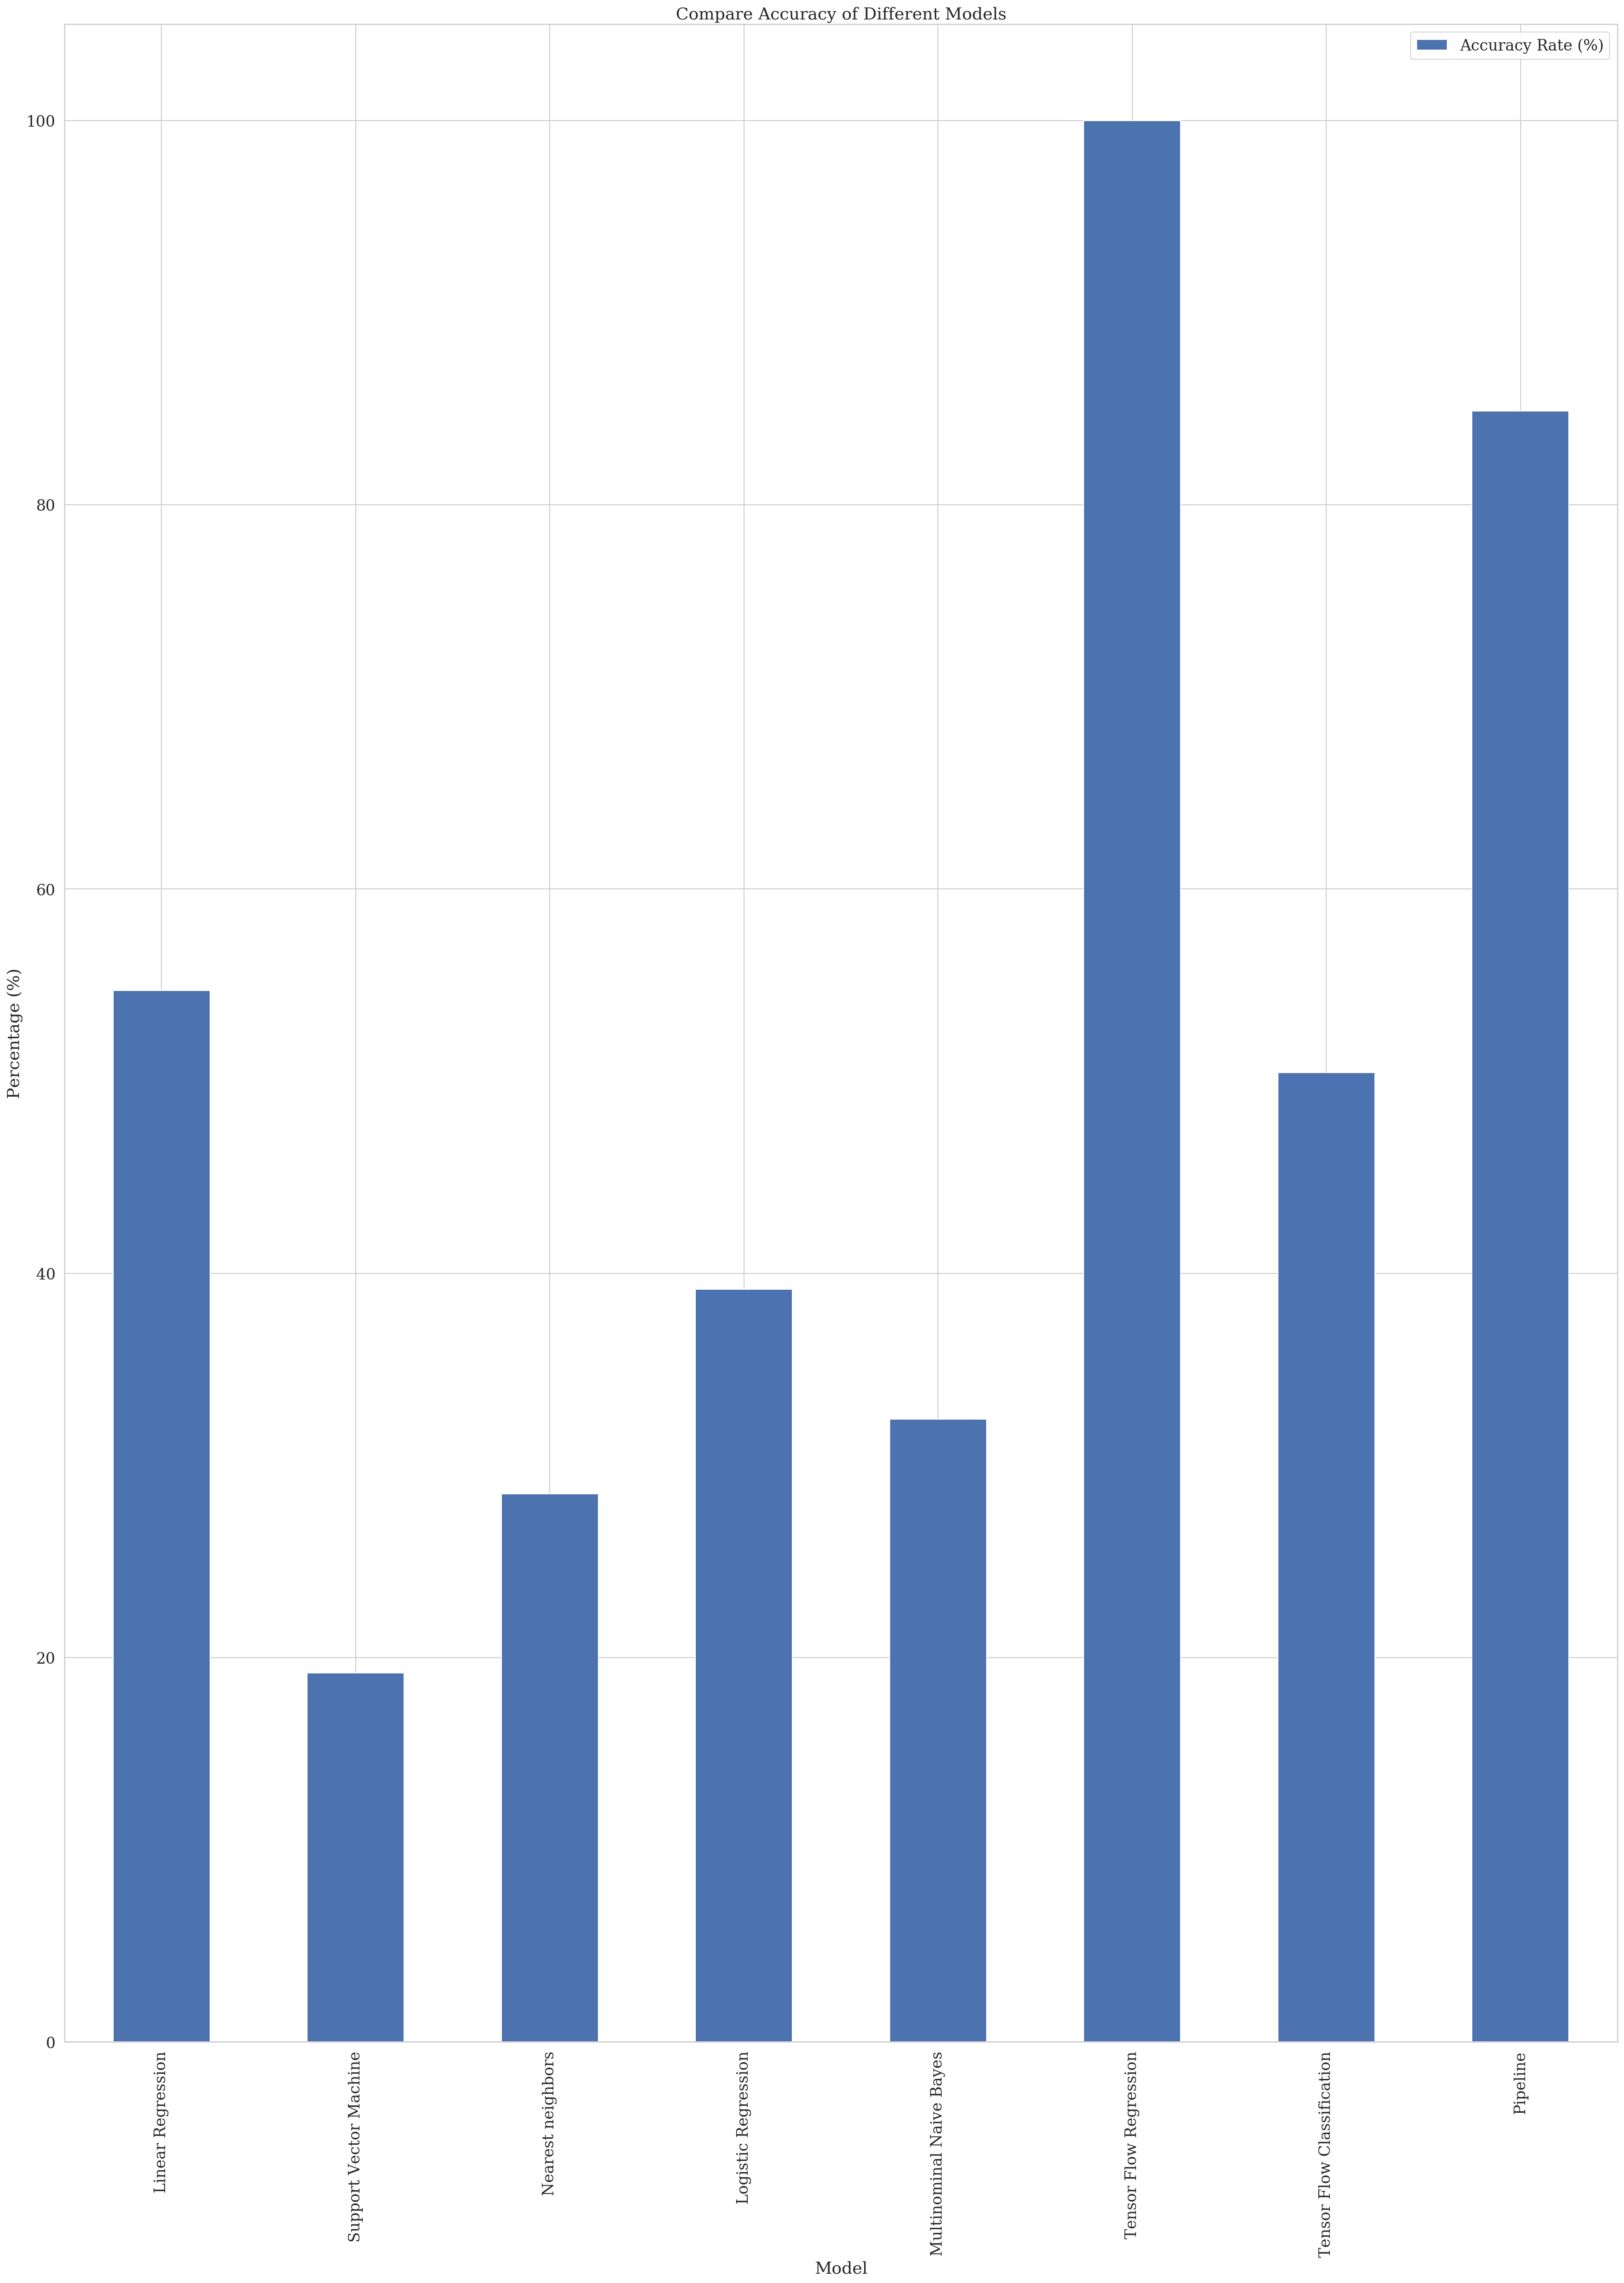

In [211]:
model_accuracy.plot.bar(x = 'Model',
                        y = 'Accuracy Rate (%)')
plt.legend()
plt.xticks(rotation = 90)
plt.title("Compare Accuracy of Different Models")
plt.ylabel('Percentage (%)')

# API:

In [216]:
input_text = input("Please Enter Review: ")

input_text = [input_text]
input_text = pd.DataFrame(input_text, columns=['a'])

# Set input to lower 
input_text['a'] = input_text['a'].str.lower()

# Remove symbols
input_text['a'] = input_text['a'].str.replace('[^\w\s]','')

print('The predicted rating stars based on entered review is:', pipeline_model.predict(input_text['a']))

Please Enter Review: completely bad
The predicted rating stars based on entered review is: [1]
